# Assignment 2: Language Modelling in Hangman

Student Name:

Student ID:

## General info

<b>Due date</b>: Wednesday, 9 April 2025 1pm

<b>Submission method</b>: Canvas submission

<b>Submission materials</b>: completed copy of this iPython notebook

<b>Late submissions</b>: -20% per day (both week and weekend days counted)

<b>Marks</b>: 8% of mark for class (with 7% on correctness + 1% on quality and efficiency of your code)

<b>Materials</b>: See "Using Jupyter Notebook and Python on Google Colab" page on Canvas (under Modules>Resources) for information on how to use Google Colab to use Jupyter Notebook. We recommend installing all the data for NLTK, since you will need various parts of it to complete this assignment. You can also use any Python built-in packages, but do not use any other 3rd party packages, <b> except </b> Numpy, Scipy, Matplotlib, Scikit-Learn, Gensim, Keras and Pytorch. You must export your Colab notebook and submit it to the LMS. If your notebook doesn't run, you will lose marks. <b> You should use the Python version that's on Google Colab (3.11)</b>.  

To familiarize yourself with NLTK, here is a free online book:  Steven Bird, Ewan Klein, and Edward Loper (2009). <a href=https://www.nltk.org/book/>Natural Language Processing with Python</a>. O'Reilly Media Inc. You may also consult the <a href=https://www.nltk.org/api/nltk.html>NLTK API</a>.

<b>Evaluation</b>: Your iPython notebook should run end-to-end without any errors in a reasonable amount of time, and you must follow all instructions provided below, including specific implementation requirements and instructions for what needs to be printed (please avoid printing output we don't ask for). You should edit the sections below where requested, but leave the rest of the code as is. You should leave the output from running your code in the iPython notebook you submit, to assist with marking. The amount each question is worth is explicitly given. 

You will be marked not only on the correctness of your methods, but also the quality and efficency of your code: in particular, you should be careful to use Python built-in functions and operators when appropriate and pick descriptive variable names that adhere to <a href="https://www.python.org/dev/peps/pep-0008/">Python style requirements</a>. If you think it might be unclear what you are doing, you should comment your code to help the marker make sense of it.

<b>Updates</b>: Any major changes to the assignment will be announced via Canvas. Minor changes and clarifications will be announced on the discussion board; we recommend you check it regularly.

<b>Academic misconduct</b>: For most people, collaboration will form a natural part of the undertaking of this homework, and we encourge you to discuss it in general terms with other students. However, this ultimately is still an individual task, and so reuse of code or other instances of clear influence will be considered cheating. We will be checking submissions for originality and will invoke the University’s <a href="http://academichonesty.unimelb.edu.au/policy.html">Academic Misconduct policy</a> where inappropriate levels of collusion or plagiarism are deemed to have taken place. You <b> must not </b> use artifial intelligence tools for doing the assignment, as all work submitted by a student should be their own, as clarified <a href="https://academicintegrity.unimelb.edu.au/plagiarism-and-collusion/artificial-intelligence-tools-and-technologies">here</a>.

# Overview

In this homework, you'll be creating an 'artificial intelligence' player for the classic Hangman word guessing game. You will need to implement several different automatic strategies based on character-level n-gram language models. Your objective is to create an automatic player which makes the fewest mistakes.

# The Hangman Game (7 marks)

**Instructions**: The <a href="https://en.wikipedia.org/wiki/Hangman_(game)">Hangman game</a> is a simple game whereby one person thinks of a word, which they keep secret from their opponent, who tries to guess the word one character at a time. The game ends when the opponent makes more than a fixed number of incorrect guesses, or they figure out the secret word before then (in which case they *win*). 

Here's a simple version of the game. **No implementation is needed.**

In [1]:
from typing import Callable

In [2]:
def hangman(secret_word, guesser, max_mistakes=8, verbose=True, **guesser_args):
    """
        This function plays the hangman game with the provided guesser and returns the number of incorrect guesses. 
        
        secret_word: a string of lower-case alphabetic characters, i.e., the answer to the game
        guesser: a function which guesses the next character at each stage in the game
            The function takes a:
                mask: what is known of the word, as a string with _ denoting an unknown character
                guessed: the set of characters which already been guessed in the game
                guesser_args: additional (optional) keyword arguments, i.e., name=value
        max_mistakes: limit on length of game, in terms of number of allowed mistakes
        verbose: silent or verbose diagnostic prints
        guesser_args: keyword arguments to pass directly to the guesser function
    """
    secret_word = secret_word.lower()
    mask = ['_'] * len(secret_word)
    guessed = set()
    if verbose:
        print("Starting hangman game. Target is", ' '.join(mask), 'length', len(secret_word))
    
    mistakes = 0
    while mistakes < max_mistakes:
        if verbose:
            print("You have", (max_mistakes-mistakes), "attempts remaining.")
        guess = guesser(mask, guessed, **guesser_args)

        if verbose:
            print('Guess is', guess)
        if guess in guessed:
            if verbose:
                print('Already guessed this before.')
            mistakes += 1
        else:
            guessed.add(guess)
            if guess in secret_word and len(guess) == 1:
                for i, c in enumerate(secret_word):
                    if c == guess:
                        mask[i] = c
                if verbose:
                    print('Good guess:', ' '.join(mask))
            else:
                if len(guess) != 1:
                    print('Please guess with only 1 character.')
                if verbose:
                    print('Sorry, try again.')
                mistakes += 1
                
        if '_' not in mask:
            if verbose:
                print('Congratulations, you won.')
            return mistakes
        
    if verbose:
        print('Out of guesses. The word was', secret_word)    
    return mistakes

Here is a human guesser allowing interactive play.

In [3]:
def human(mask, guessed, **kwargs):
    """
    This is a simple function for manual play.
    """
    print('\nEnter your guess:')
    return input().lower().strip()

If you want to play hangman interactively, please set `interactive` to `True`. When submitting your solution, set to `False` so we can automatically run the whole notebook using `Run All`.

In [4]:
interactive = False  #todo change this to false

<b>For your testing:</b>

You can play the game interactively using the following command:

In [5]:
if interactive:
    hangman('whatever', human, 8, True)

### Question 1 (1.0 mark)

**Instructions**: We will use the words in NLTK's Brown corpus for training an artificial intelligence guessing algorithm, and for evaluating the quality of the algorithm.

Your first task is to compute the number of **unique word types** occurring in the Brown corpus, using `nltk.corpus.brown` and the `words` method, and select only words that are **entirely comprised of alphabetic characters**. You should also **lowercase the words**. Finally, randomly shuffle (`numpy.random.shuffle`) this collection of word types, and split them into disjoint training and testing sets. The test set should contain 1000 word types, and the rest should be in the  training set. Note that we are intentionally making the hangman game hard, as the AI will need to cope with test words that it has not seen before, hence it will need to learn generalisable patterns of characters to make reasonable predictions.

**Task**: Collect all unique word types from the Brown corpus, and produce `training_set` and `test_set`, 2 lists that contain 2 disjointed sets of words. Both `training_set` and `test_set` should be a python `list` (as initialised in the code). `test_set` must contain exactly 1000 word types.

**Check**: Use the assertion statements in <b>"For your testing"</b> below for the expected output.

In [6]:
import nltk
from nltk.corpus import brown
import numpy as np

nltk.download('brown')
np.random.seed(1)

[nltk_data] Downloading package brown to /home/highorder/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [ ]:

# training_set stores the rest word types for training
training_set = []
# test_set stores 1000 word types for testing
test_set = []


###
# Your answer BEGINS HERE
###
# Get all words from brown corpus and filter them
def split_corpus() -> tuple[list[str], list[str]]:
    words = brown.words()
    filtered_words = [word.lower() for word in words if word.isalpha()]
    unique_words = list(set(filtered_words))
    np.random.shuffle(unique_words)
    test_set = unique_words[:1000]
    training_set = unique_words[1000:]
    return training_set, test_set

training_set, test_set = split_corpus()
###
# Your answer ENDS HERE
###

print("Number of word types in test =", len(test_set))
print("Number of word types in train =", len(training_set))

Number of word types in test = 1000
Number of word types in train = 39234


<b>For your testing:</b>

In [8]:
assert(len(training_set) > 35000 and len(training_set) < 45000)
assert(len(training_set) == 39234) # added test
assert(len(test_set) == 1000)

**Play the game**:

Let's see how good you are at this game! Try to guess a random word from the test set. It is surprisingly difficult (and addictive)! Don't forget to set `interactive = True`.

In [9]:
#play hangman using random words from test set
if interactive:
    hangman(np.random.choice(test_set), human, 8, True)

### Question 2 (0.5 mark)

**Instructions**: To set a baseline, your first AI attempt will be a trivial **random method**. For this you should implement a guessing method, similar to the `human` method above, i.e., using the same input arguments and returning a character. Your method should randomly choose a character from the range `a ... z` after excluding the characters that have already been guessed in the current game (all subsequent AI approaches should also exclude previous guesses).

To help you measure the performance of this (and later) guesser, a `test_guesser` method that takes a guesser and measures the average number of incorrect guesses made over all the words in the `test` is provided to you. 

**Task**: Complete the `random_guesser` method. It should return a random character from the English alphabets.

**Check**: Use the assertion statements in <b>"For your testing"</b> below for the expected output.

In [10]:
def test_guesser(guesser: Callable, test: list[str]) -> float:
    """
        This function takes a guesser and measures the average number of incorrect guesses made over all the words in the test_set. 
        
        Args:
            guesser (Callable): A function that takes a mask string, set of guessed chars and returns a char guess
            test (list[str]): List of words to test the guesser on
            
        Returns:
            float: Average number of incorrect guesses across all test words
            
        Example:
            >>> def simple_guesser(mask: str, guessed: set[str], **kwargs) -> str:
            ...     return 'e'  # Always guess 'e'
            >>> test_words = ['hello', 'world']
            >>> test_guesser(simple_guesser, test_words)
            2.5  # Average number of wrong guesses
    """
    total = 0
    for word in test:
        total += hangman(word, guesser, 26, False)
    return total / float(len(test))

In [11]:
def random_guesser(mask: str, guessed: set[str], **kwargs) -> str:
    """
    Just return a random character from the English alphabet
    
    Args:
        mask (str): The current state of the word with unguessed letters as '_'
        guessed (set[str]): Set of characters that have already been guessed
        **kwargs: Additional keyword arguments (not used)
        
    Returns:
        str: A random unguessed character from a-z
        
    Example:
        >>> mask = "h_ll_"
        >>> guessed = {'h', 'l'} 
        >>> random_guesser(mask, guessed)
        'e'  # Returns random letter that isn't 'h' or 'l'
    """
    
    ###
    # Your answer BEGINS HERE
    ###
    # Get all letters from a-z
    alphabet = set('abcdefghijklmnopqrstuvwxyz')
    
    # need to remove already guessed letters
    available = alphabet - guessed
    
    # Return random letter from remaining available letters
    return np.random.choice(list(available))
    ###
    # Your answer ENDS HERE
    ###

random_word = np.random.choice(test_set)
print("Guessing word =", random_word)
print("Number of mistakes made by the random guesser =", hangman(random_word, random_guesser, 26, False))

result = test_guesser(random_guesser, test_set)
print("\nTesting the random guesser using every word in test set")
print("Average number of incorrect guesses: ", result)

Guessing word = costs
Number of mistakes made by the random guesser = 19

Testing the random guesser using every word in test set
Average number of incorrect guesses:  16.52


<b>For your testing:</b>

In [12]:
assert(result > 10 and result < 20)

### Question 3 (1.0 mark)

**Instructions:** As your first real AI, you should train a **unigram language model** over the training set. This requires you to find the frequencies of characters over all training words. Using this model, you should write a guesser that returns the character with the highest probability. Remember to exclude already guessed characters. 

**Task**: Collect the frequencies of characters and store them in `unigram_counts` (use the first answer space). Complete the `unigram_guesser` method (use the second answer space). Note that it takes `unigram_counts` as an additional argument.

**Check**: Use the assertion statements in <b>"For your testing"</b> below for the expected output.

In [13]:
unigram_counts = None

###
# Your answer BEGINS HERE

###
# Initialize empty dictionary for character counts
unigram_counts = {}

# Loop through each word in training set
for word in training_set:
    # Loop through each character in word
    for char in word:
        # Increment count for this character
        if char in unigram_counts:
            unigram_counts[char] += 1
        else:
            unigram_counts[char] = 1


###
# Your answer ENDS HERE
###

def unigram_guesser(mask: str, guessed: set, unigram_counts=unigram_counts) -> str:
    """Guess next letter based on unigram probabilities.
    
    Uses unigram language model to select the most probable character that hasn't been guessed yet.
    
    P(c) = count(c) / N, where N is total character count
    
    Args:
        mask: Current game state showing revealed letters and underscores for hidden letters
        guessed: Set of letters that have already been guessed
        unigram_counts: Dictionary mapping characters to their counts in training data
    
    Returns:
        str: Most probable unguessed character
        
    Example:
        >>> mask = "h_ll_"
        >>> guessed = {'h','l'} 
        >>> unigram_counts = {'e':10, 'o':8, 'a':5}
        >>> unigram_guesser(mask, guessed, unigram_counts)
        'e'
    """
    ###
    # Your answer BEGINS HERE
    ###
    
    # Find character with highest count that hasn't been guessed yet
    max_count = 0
    best_char = None
    
    for char, count in unigram_counts.items():
        # Skip if already guessed
        if char in guessed:
            continue
            
        if count > max_count:
            max_count = count
            best_char = char
            
    return best_char

    ###
    # Your answer ENDS HERE
    ###

result = test_guesser(unigram_guesser, test_set)
print("Testing the unigram guesser using every word in test set")
print("Average number of incorrect guesses: ", result)


Testing the unigram guesser using every word in test set
Average number of incorrect guesses:  10.489


<b>For your testing:</b>

In [14]:
#h Assert result is 10.32
# assert(result == 10.32)

### Question 4 (1.0 mark)

**Instructions:** The length of the secret word is an important clue that we might exploit. Different lengths tend to have different distributions over characters, e.g., short words are less likely to have suffixes or prefixes. You should incorporate this idea by conditioning the unigram model on the length of the secret word, i.e.,  having a **different unigram model for each length**. You will need to be a little careful at test time, to be robust to the situation that you encounter a word length that you didn't see in training. In such a case, your method should behave like the previous `unigram_guesser` in Question 3 (i.e., it guesses characters based on unigram frequencies, unconditioned by the word length).

**Task**: Collect the frequencies of characters conditioned on the word length and store them in `unigram_counts_by_length` (use the first answer space). Complete the `unigram_length_guesser` method (use the second answer space).

**Check**: Use the assertion statements in <b>"For your testing"</b> below for the expected output.

In [15]:
unigram_counts_by_length = None

###
# Your answer BEGINS HERE
###

def calculate_unigram_counts_by_length(words: list[str]) -> dict[int, dict[str, int]]:
    unigram_counts_by_length = {}
    
    for word in words:
        length = len(word)
        
        # Initialize dictionary for this length if it doesn't exist
        if length not in unigram_counts_by_length:
            unigram_counts_by_length[length] = {}
        
        # Count each character in the word
        for char in word:
            if char in unigram_counts_by_length[length]:
                unigram_counts_by_length[length][char] += 1
            else:
                unigram_counts_by_length[length][char] = 1
    
    return unigram_counts_by_length

unigram_counts_by_length = calculate_unigram_counts_by_length(training_set)

###
# Your answer ENDS HERE
###

def unigram_length_guesser(mask: str, guessed: set[str], unigram_counts_by_length: dict[int, dict[str, int]]=unigram_counts_by_length, unigram_counts: dict[str, int]=unigram_counts) -> str:
    """
    Makes a guess for the next character based on unigram frequencies conditioned on word length.
    Falls back to unconditioned unigram frequencies for unseen word lengths.

    Example:
        >>> mask = "h_ll_"  # 5 letter word
        >>> guessed = {"h", "l"}
        >>> unigram_length_guesser(mask, guessed)  # Returns most likely unguessed char for 5-letter words
        'e'

    Args:
        mask: The current state of the word with _ for unknown letters
        guessed: Set of letters that have already been guessed
        unigram_counts_by_length: Dict mapping word lengths to character frequency dicts
        unigram_counts: Dict mapping characters to their frequencies (fallback)

    Returns:
        The most likely unguessed character
    """
    ###
    # Your answer BEGINS HERE
    ###
    
    length = len(mask)
    
    # If we haven't seen this word length before, fall back to regular unigram counts
    if length in unigram_counts_by_length:
        
    
        # Use length-specific unigram counts
        max_count = 0
        best_char = None
        
        for char, count in unigram_counts_by_length[length].items():
            if char not in guessed and count > max_count:
                max_count = count
                best_char = char

        # if not best_char:
        #     print(mask,guessed)
                
        if best_char: 
            return best_char
    
    
    max_count = 0
    best_char = None
    
    for char, count in unigram_counts.items():
        if char not in guessed and count > max_count:
            max_count = count
            best_char = char
            
    return best_char

    ###
    # Your answer ENDS HERE
    ###

result = test_guesser(unigram_length_guesser, test_set)
print("Testing the length-conditioned unigram guesser using every word in test set")
print("Average number of incorrect guesses: ", result)

Testing the length-conditioned unigram guesser using every word in test set
Average number of incorrect guesses:  10.469


<b>For your testing:</b>

In [16]:
assert(result > 5 and result < 15)
# assert(result == 10.256) #h added test

### Question 5 (1.0 mark)

**Instructions:** Now for the next challenge, you'll build a **bigram language model** over characters. The order of characters is obviously important, yet this wasn't incorporated in any of the above models. Knowing that the word has the sequence `n _ s s` is a pretty strong clue that the missing character might be `e`. Similarly the distribution over characters that start or end a word are highly biased (e.g., toward common prefixes and suffixes, like *un-*, *-ed* and *-ly*).

The task here is to develop a bigram language model over characters, and train it over the training words. Remember to be careful when handling the start of each word properly, e.g., by padding with a special starting symbol such as `$`. Do we also need a special ending symbol? That's for you to decide.

Your bigram guesser should apply your language model to each blank position in the secret word by using its left context character. For example, in the partial word `e _ c _ b _ _` we know the left context for the first three blanks, but have no known left context for the last blank. In the case for the last blank, you should revert to using a unigram language model (since there's no context for us to use the bigram model). You should sum up the probability distribution (over all alphabets from <i>a</i> to <i>z</i>) for the 4 blanks, and select the alphabet with the highest probability that hasn't been guessed.

**Note**:
- When backing-off to the unigram language model, you **must use the vanilla unigram language model that you have built in Q3**. Do not use the length-based unigram language model, or any fancy variant, or you will lose marks.
- You should build a **standard bigram language model**; i.e. do not do anything complicated like a bidirectional bigram language model.

**Task**: Collect frequency counts that are necessary for building a bigram language model and store them in bigram_counts; feel free to add new objects if needed (use the first answer space). Complete the `bigram_guesser` method (use the second answer space). Note that the method currently only has one additional argument (`bigram_counts`), but you are free to add additional arguments.

In [38]:
bigram_counts = None

###
# Your answer BEGINS HERE
###
"""#h
first go through each word in the corpus
    for each word, for the charactor before it, code the frequency of the charactor after it, 
    unless start, which goes to a sperate thing

example
    leet, chad
      ^
    forward_bigram_dict {
    '$': {l:1},
    'l': {e:1},
    'e' :{e:1,t:1},
      }

questions
  do we need a special end symbol?
training_set

"""
from collections import defaultdict

def build_forward_bigram_dict(training_set):
    forward_bigram_dict = defaultdict(lambda: defaultdict(int))
    for word in training_set:
        for i in range(len(word)):
            c = word[i]
            if i == 0:
                forward_bigram_dict['$'][c] += 1
            else:
                prev_c = word[i-1]
                forward_bigram_dict[prev_c][c] += 1
    return forward_bigram_dict

forward_bigram_dict = build_forward_bigram_dict(training_set)


###
# Your answer ENDS HERE
###
    

def bigram_guesser(mask: str, guessed: set[str], bigram_counts=bigram_counts) -> str:
    """Guess the next letter using a bigram language model.
    
    The probability of a character c following character p is:
    P(c|p) = count(p,c) / count(prev) # should be summed prev from the bigram dictionary
    
    hell_

    
    Where:
    - count(p,c) is the number of times character c follows p in training data
    - count(p) is total number of characters that follow p
    
    Examples:
        >>> mask = "h_ll_"
        >>> guessed = {'h', 'l'} 
        >>> bigram_guesser(mask, guessed)
        'e'  # High probability of 'e' following 'h' in "hello"
        
        >>> mask = "_at" 
        >>> guessed = {'t', 'a'}
        >>> bigram_guesser(mask, guessed)
        'c'  # 'c' likely to start "cat" based on training data

        C_t_
        cat

        hello
        h_ll_
        he
        le


    """
    ###
    # Your answer BEGINS HERE
    ###
    """
    #h probably could optimise but hey
    process
    
        

    example:
    $h_ll_
      ^

    have to divide by total 

    """
    def bigram_sum(prev):
      values = [val for key, val in forward_bigram_dict[prev].items()]
      total = sum(values)
      return total
    
    unigram_total = sum([val for key, val in unigram_counts.items()])

    alphabet = 'abcdefghijklmnopqrstuvwxyz'

    char_prob_dict = defaultdict(int)
    # print(mask)
    mask = ['$']+ mask
    for i in range(1,len(mask)):
      c = mask[i]
      #technically its count
      if c == '_':
        """
        example:
        $h_ll_
         ^
        """
        for guess in alphabet:
          if guess in guessed:
            continue
          prev = mask[i-1]
          if prev == '_':
            probability = unigram_counts[guess] / unigram_total
            assert 0<probability<1
          else:
            p_prev = bigram_sum(prev)
            p_c = forward_bigram_dict[prev][guess]
            # if p_c == 0:
            #    print('true')
            #smoothing?
            probability = 0
            if not p_c == 0:
              probability =  p_c /p_prev

          char_prob_dict[guess] += probability
        

    largest_prob = 0
    largest_guess = None
    for guess, prob in char_prob_dict.items():
      if prob > largest_prob and guess not in guessed:
        largest_prob = prob
        largest_guess = guess

    

    if not largest_guess:
        def fallback_guess(word, guessed: set[str]) -> str:
          """
          Makes a fallback guess based on character frequency by word length, with unigram fallback.
          
          Args:
              word: Current word state (can be list or string)
              guessed: Set of already guessed characters
                  
          Returns:
              Most likely unguessed character
          """
          print("Warning: Using fallback guesser. This may indicate insufficient data for a more accurate guess.")
          
          # Convert list to string if needed
          if isinstance(word, list):
              word = ''.join(word)
          
          # Remove $ if present at beginning
          if word.startswith('$'):
              word = word[1:]
          
          length = len(word)
          
          # First try: use length-specific character frequencies
          if length in unigram_counts_by_length:
              max_count = 0
              best_char = None
              
              for char, count in unigram_counts_by_length[length].items():
                  if char not in guessed and count > max_count:
                      max_count = count
                      best_char = char
              
              if best_char:
                  return best_char
          
          # Second try: fall back to global unigram frequencies
          max_count = 0
          best_char = None
          
          for char, count in unigram_counts.items():
              if char not in guessed and count > max_count:
                  max_count = count
                  best_char = char
          
          if best_char:
              return best_char
          
          # Last resort: pick any remaining unguessed letter
          alphabet = set('abcdefghijklmnopqrstuvwxyz')
          available = alphabet - guessed
          
          if available:
              return np.random.choice(list(available))
          
          # This should never happen in a normal game
          assert False, "Unexpected state: all letters guessed"
        
        
        
        
    
        
  
        # print(mask,guessed)
        return fallback_guess(mask, guessed)

    return largest_guess
    
    ###
    # Your answer ENDS HERE
    ###



result = test_guesser(bigram_guesser, test_set)
print("Testing the bigram guesser using every word in test set")
print("Average number of incorrect guesses: ", result)

Testing the bigram guesser using every word in test set
Average number of incorrect guesses:  8.696


In [18]:
def bigram_sum(prev):
      values = [val for key, val in forward_bigram_dict[prev].items()]
      total = sum(values)
      return total

assert bigram_sum('$') == len(training_set)

### Question 6 (2.0 mark)

**Instructions:** You should try to develop a more effective AI for hangman. Feel free to engage your creativity here! Possibilities include better conditioning on the length of the word, fancier smoothing methods, ngram models and bidirectional models (lecture 8). Have fun!

You will be marked based on the performance of your AI model, using a pre-made training and test set (created using a secret seed). Let x be the average number of mistakes in the test set, you will score:
* 2.0 mark if x < 6.0
* 1.5 mark if 6.0 <= x < 6.5
* 1.0 mark if 6.5 <= x < 7.0
* 0.5 mark if 7.0 <= x < 8.0
* 0.0 mark if x >= 8.0

Note:
* When testing your AI model's performance, you may want to consider trying different training/test splits (using different seeds) to have a better understanding of its _average_ performance, as there will be some variance to its performance depending on the training/test split.
* Your code must run under 2 minutes on Colab (free account) with GPU; program that runs longer than that will be terminated and you will score 0.

**Task** Complete the `my_amazing_ai_guesser` method, which implements a better language model for hangman.

In [19]:
def sort_and_print_unigram_counts(unigram_counts_by_length):
    """
    Sorts and prints the unigram counts dictionary by word length (ascending)
    and letter frequency (descending).
    
    Args:
        unigram_counts_by_length: Dictionary mapping word lengths to character frequency dictionaries
        
    Returns:
        Sorted dictionary with same structure but ordered entries
    """
    sorted_dict = {}
    
    # Sort by length (ascending)
    for length in sorted(unigram_counts_by_length.keys()):
        # Get character frequency dictionary for this length
        char_counts = unigram_counts_by_length[length]
        
        # Sort characters by frequency (descending)
        sorted_chars = {char: count for char, count in 
                       sorted(char_counts.items(), key=lambda x: x[1], reverse=True)}
        
        # Add to result dictionary
        sorted_dict[length] = sorted_chars
        
        # Print this length section
        print(f"Word length {length}:")
        for char, count in sorted_chars.items():
            print(f"  '{char}': {count}")
        print()
    
    return sorted_dict

# Call the function with your dictionary
sorted_dict = sort_and_print_unigram_counts(unigram_counts_by_length)


Word length 1:
  'j': 1
  'k': 1
  'l': 1
  'p': 1
  'v': 1
  'w': 1
  'y': 1
  't': 1
  'b': 1
  'c': 1
  'q': 1
  'f': 1
  'a': 1
  'm': 1
  'n': 1
  'z': 1
  'h': 1
  'i': 1
  's': 1
  'd': 1
  'o': 1
  'e': 1
  'g': 1
  'x': 1
  'u': 1
  'r': 1

Word length 2:
  'a': 26
  'e': 21
  'o': 19
  's': 19
  'm': 17
  'i': 15
  'l': 12
  'h': 12
  't': 11
  'p': 11
  'd': 11
  'n': 11
  'u': 11
  'c': 11
  'f': 9
  'b': 9
  'r': 9
  'w': 7
  'v': 6
  'g': 6
  'j': 5
  'y': 5
  'k': 5
  'x': 3
  'q': 2
  'z': 1

Word length 3:
  'a': 235
  'e': 195
  'o': 179
  'i': 129
  'n': 118
  't': 114
  's': 114
  'p': 103
  'u': 102
  'm': 100
  'r': 98
  'd': 97
  'b': 92
  'l': 79
  'h': 78
  'g': 77
  'y': 76
  'w': 72
  'c': 66
  'f': 53
  'k': 32
  'j': 29
  'v': 24
  'x': 23
  'z': 10
  'q': 6

Word length 4:
  'e': 905
  'a': 871
  's': 693
  'o': 673
  'l': 554
  'i': 538
  'r': 523
  't': 489
  'n': 471
  'd': 361
  'u': 349
  'h': 294
  'm': 292
  'p': 285
  'c': 258
  'b': 257
  'k': 225

In [20]:


def sort_words_by_length(training_set: list[str]) -> dict[int, list[str]]:
    """
    Sorts words into a dictionary with word lengths as keys. ()
    
    Args:
        training_set: List of words to sort.
        
    Returns:
        Dictionary with word lengths as keys and lists of words as values.
    """
    length_dict: dict[int, list[str]] = {}
    for word in training_set:
        length = len(word)
        if length not in length_dict:
            length_dict[length] = []
        length_dict[length].append(word)
    return length_dict

# Example usage
length_dict = sort_words_by_length(training_set)
print(length_dict)


{10: ['ridiculing', 'captivated', 'spacecraft', 'birmingham', 'bestimmung', 'emblematic', 'septillion', 'sinusoidal', 'handsomely', 'statements', 'vigorously', 'fernberger', 'appetizing', 'floridians', 'pronounced', 'capability', 'hesitantly', 'tippecanoe', 'norristown', 'copernican', 'disfigured', 'laminating', 'separating', 'yugoslavia', 'transforms', 'renderings', 'plundering', 'harmonious', 'inoperable', 'semidrying', 'overpriced', 'biographer', 'structured', 'everything', 'compliance', 'overridden', 'nineteenth', 'unbearable', 'hengesbach', 'proportion', 'unavailing', 'blockhouse', 'metrically', 'preferring', 'uncombable', 'beatitudes', 'educations', 'inherently', 'transistor', 'conducting', 'identified', 'reassemble', 'revitalize', 'optimality', 'endeavours', 'soothingly', 'launchings', 'burdensome', 'precipitin', 'hanoverian', 'democratic', 'woodcarver', 'multiplied', 'bridgehead', 'reaffirmed', 'shortening', 'contraband', 'wordsworth', 'cerebellum', 'perishable', 'mercifully', 

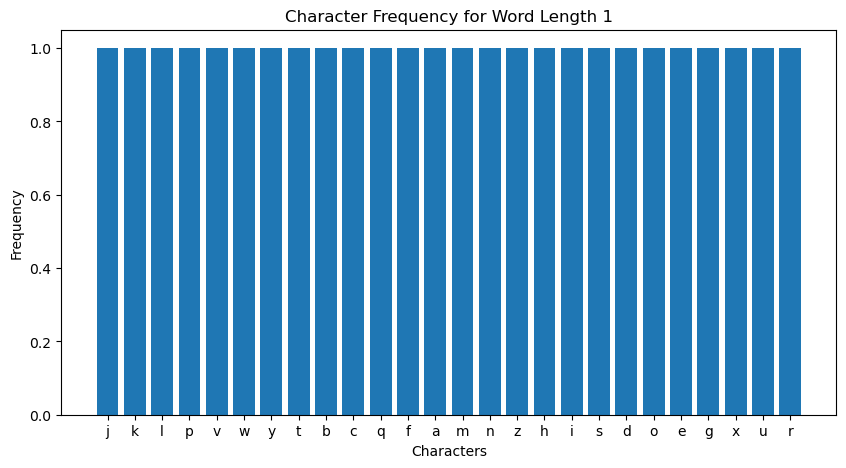

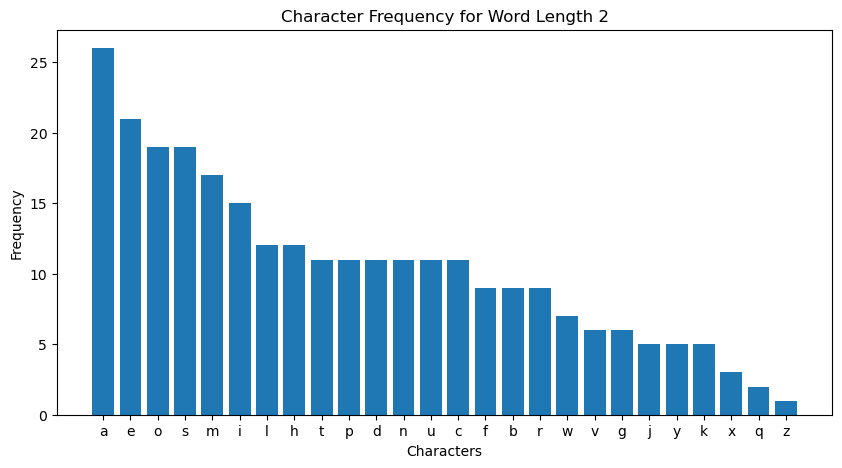

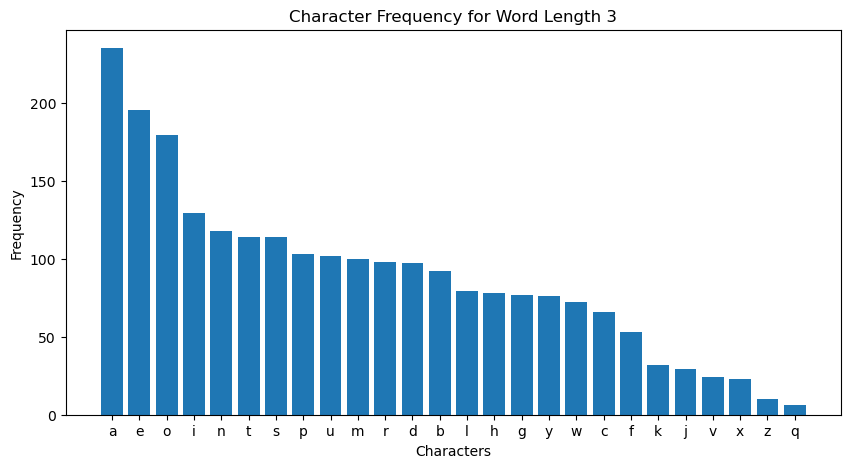

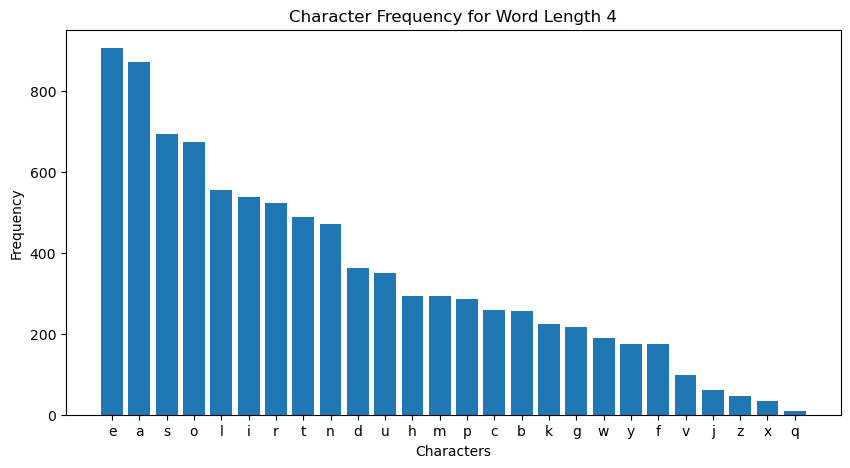

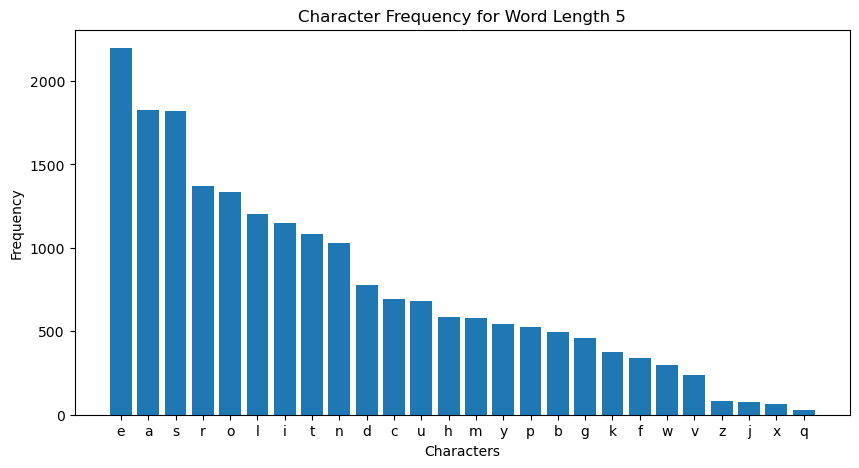

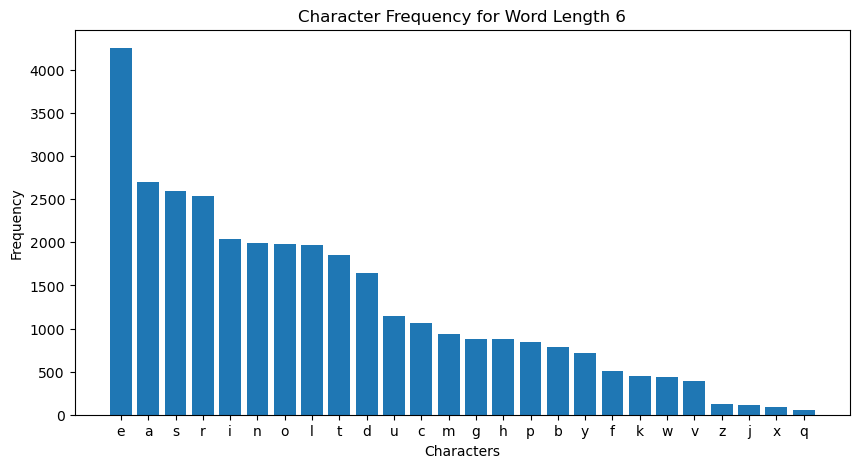

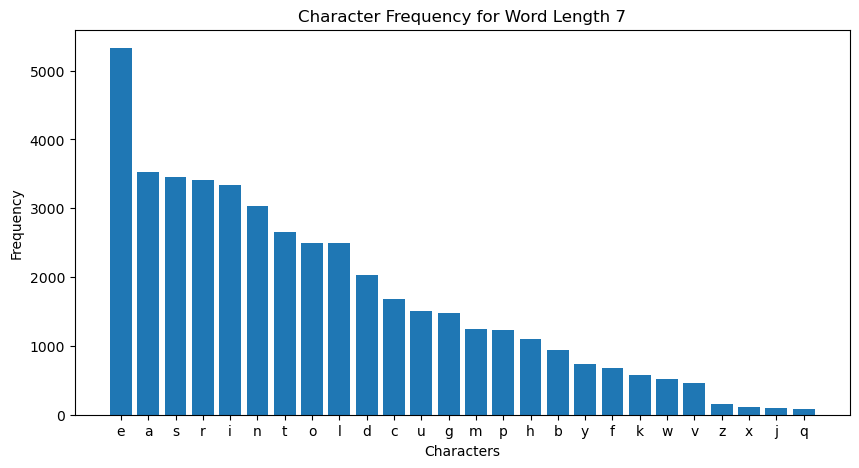

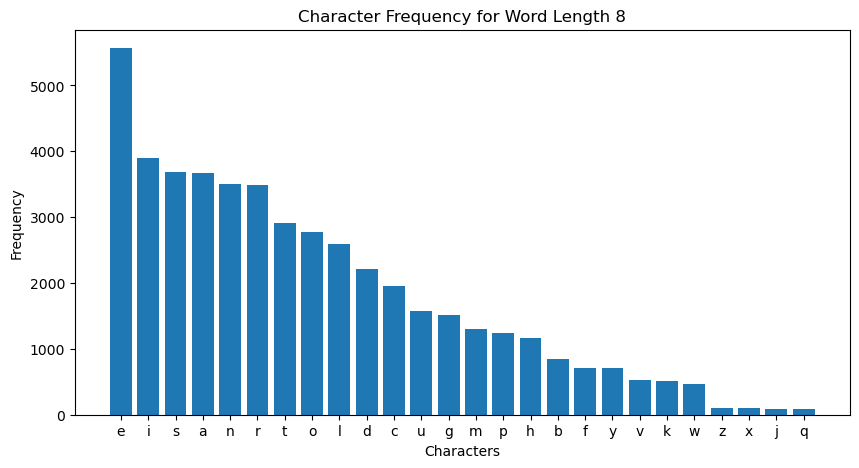

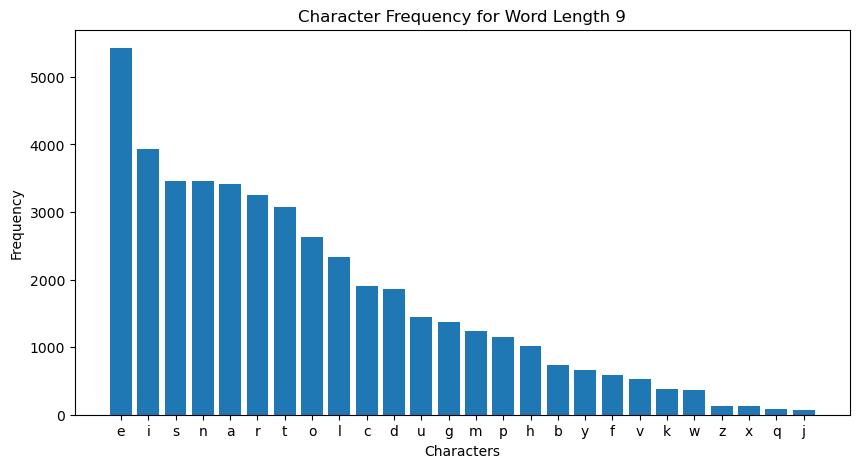

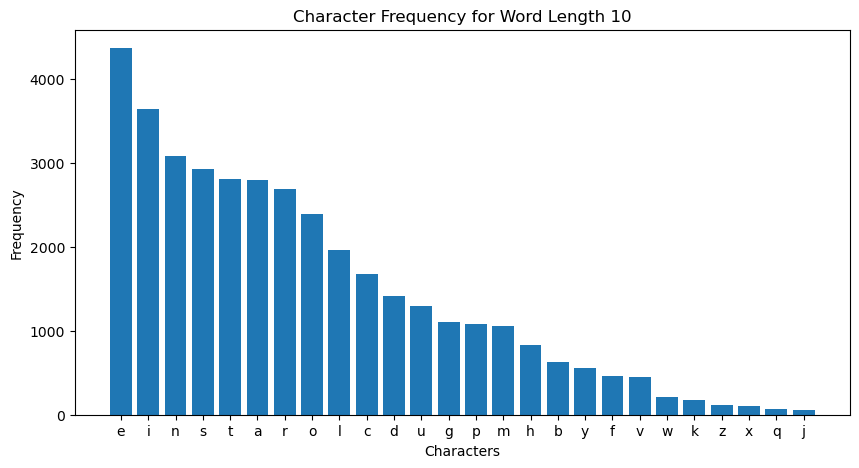

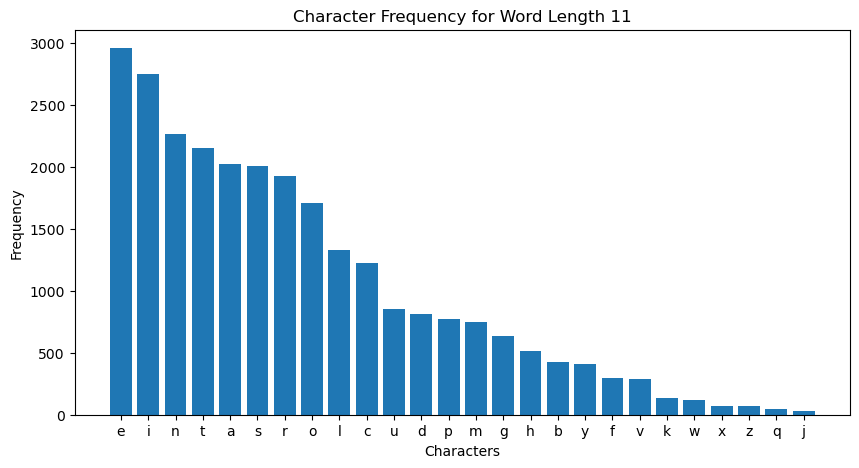

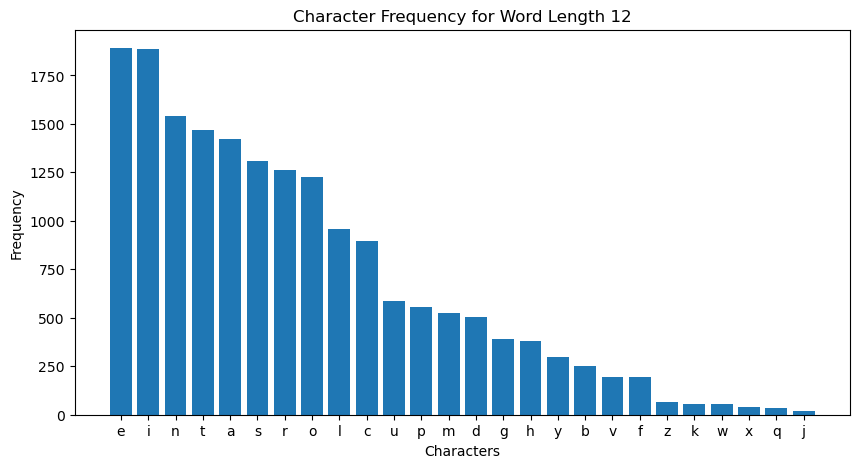

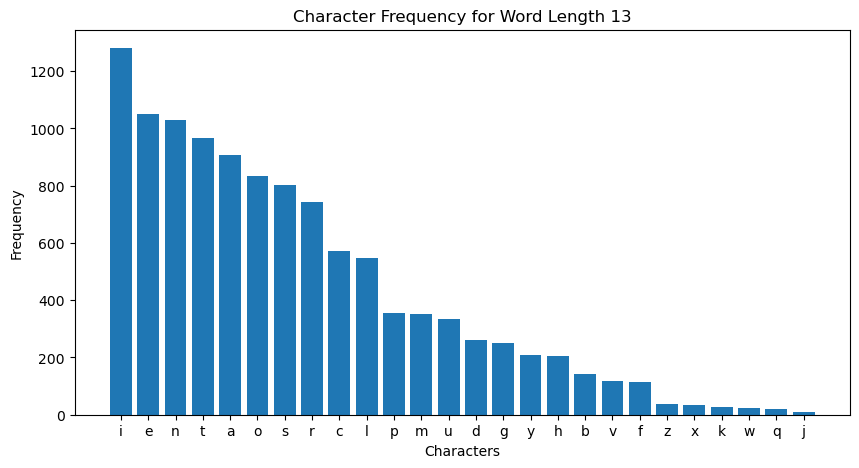

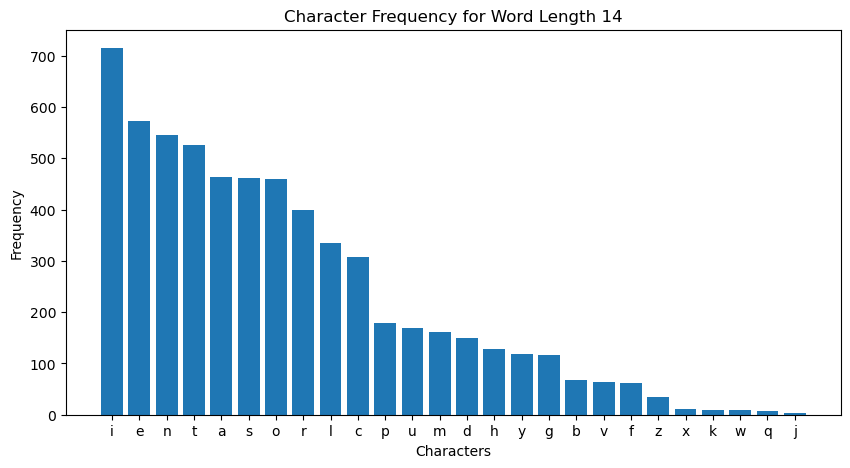

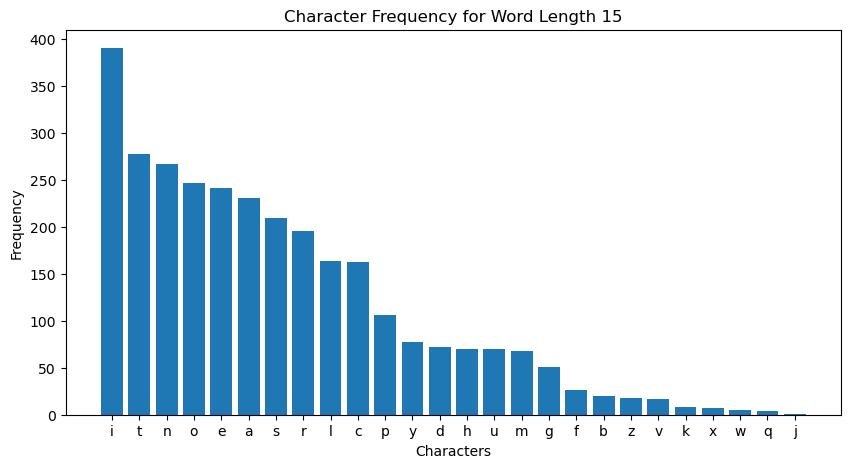

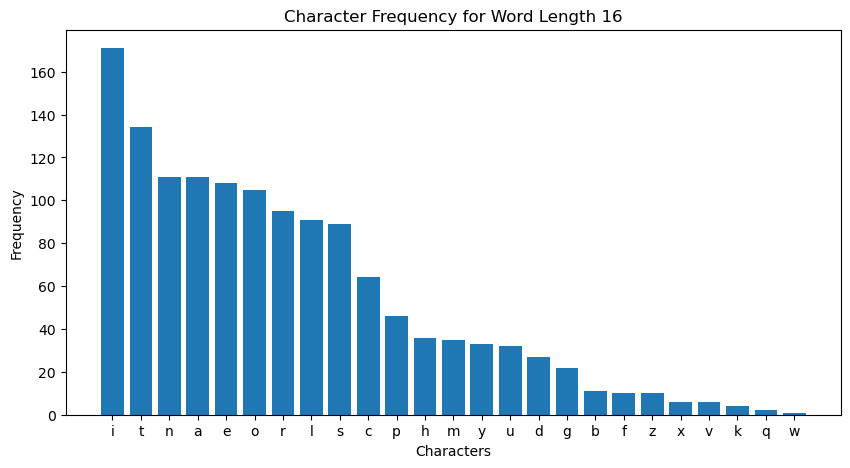

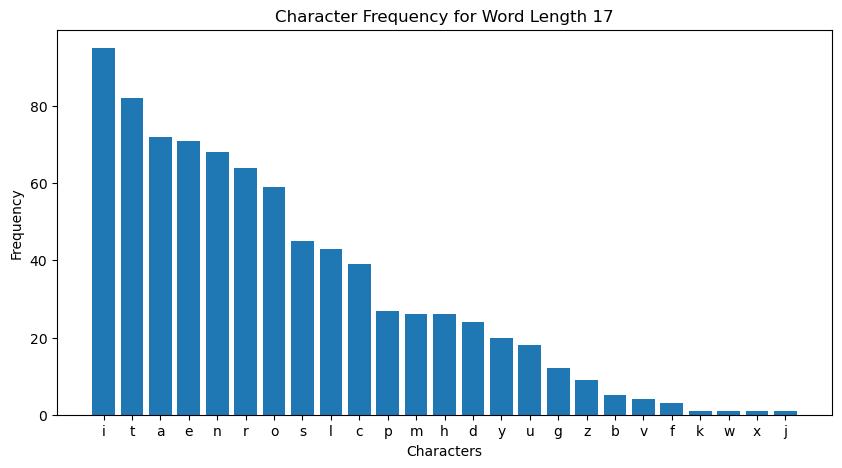

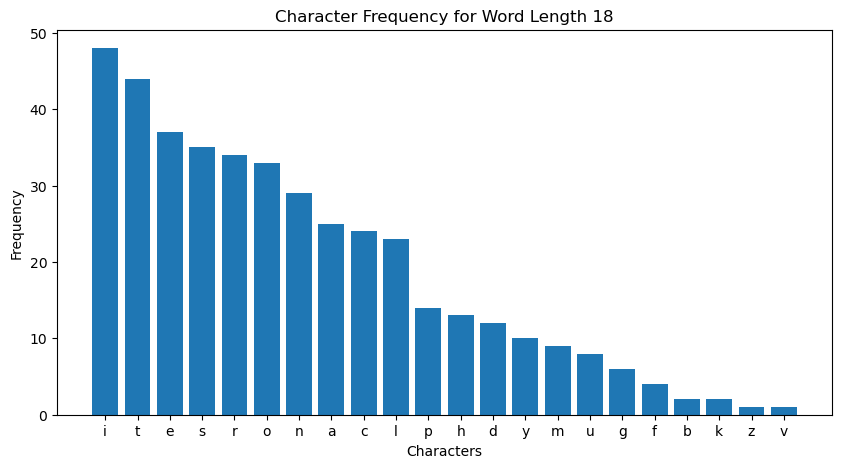

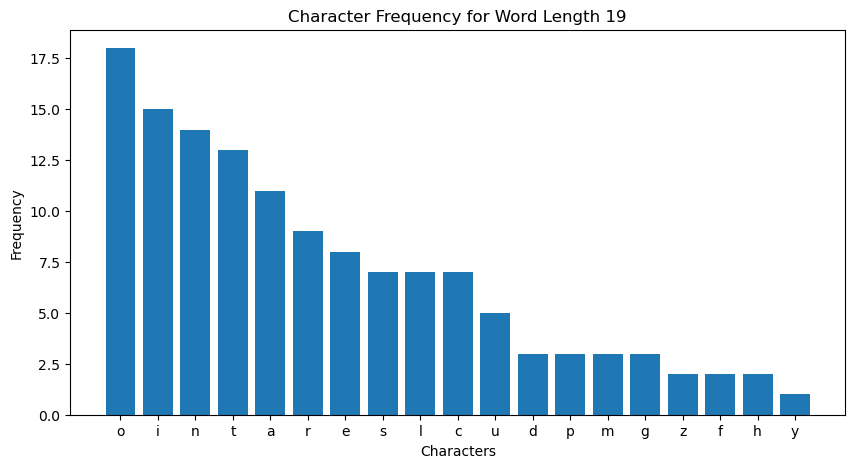

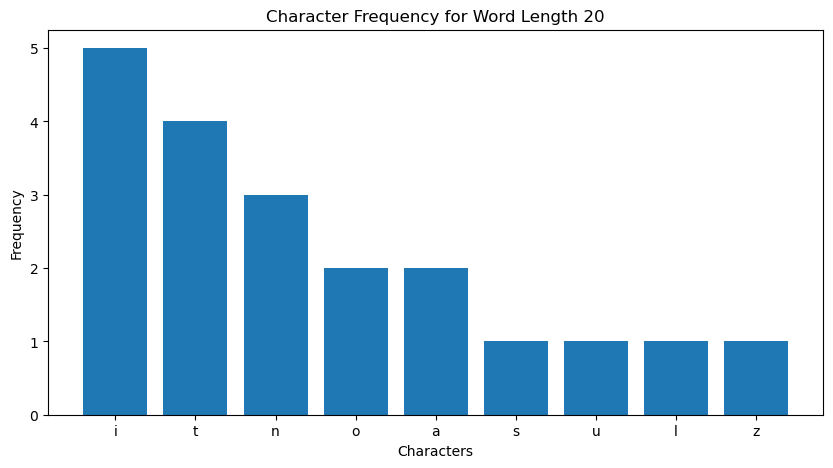

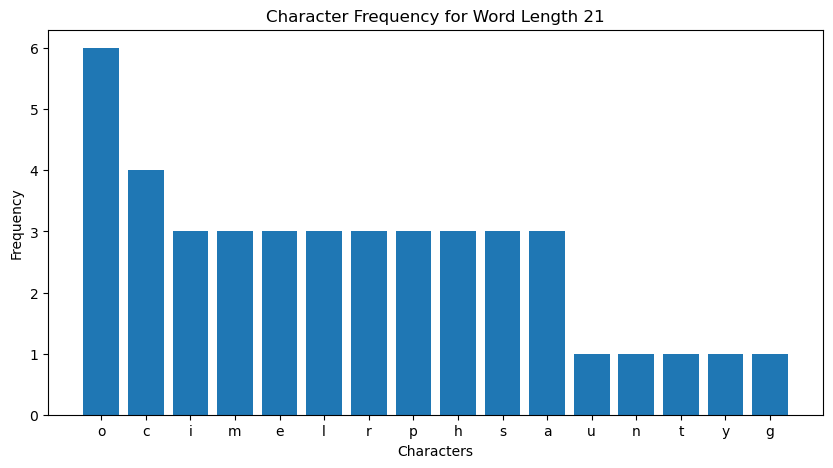

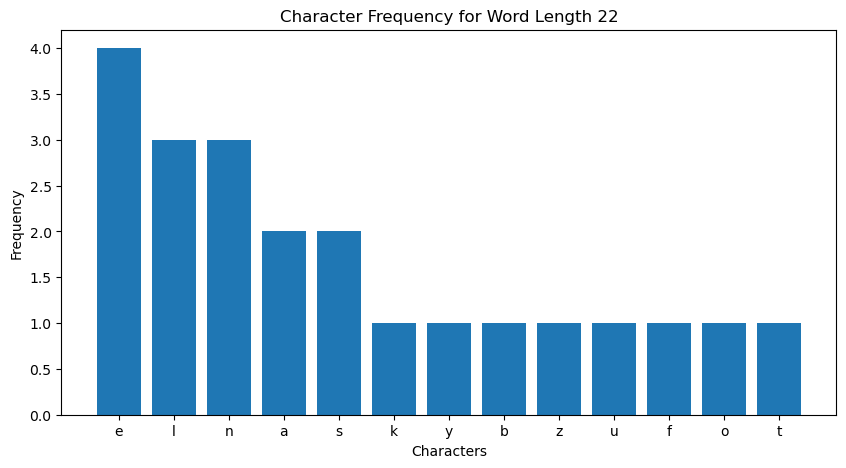

In [21]:
import matplotlib.pyplot as plt

def display_histogram(unigram_counts_by_length):
    """
    Displays a histogram for each length of unigram counts.
    
    Args:
        unigram_counts_by_length: Dictionary with word lengths as keys and character frequency dictionaries as values.
    """
    for length, char_counts in sorted(unigram_counts_by_length.items()):
        sorted_char_counts = dict(sorted(char_counts.items(), key=lambda item: item[1], reverse=True))
        plt.figure(figsize=(10, 5))
        plt.bar(sorted_char_counts.keys(), sorted_char_counts.values())
        plt.title(f'Character Frequency for Word Length {length}')
        plt.xlabel('Characters')
        plt.ylabel('Frequency')
        plt.show()

# Example usage
display_histogram(unigram_counts_by_length)

In [22]:
import time
import numpy as np

def filter_words_by_mask(mask: list[str], guessed: set, corpus: list[str]) -> dict:
    """
    Filters the training set for words that match the given mask and have not been guessed.
    
    Args:
        mask: List representing the current state of the word with guessed letters and blanks.
        guessed: Set of letters that have already been guessed.
        corpus: List of words to filter from.
        
    Returns:
        Dictionary with characters as keys that could be in the masked positions and their probabilities.
    """
    ALPHABET = 'abcdefghijklmnopqrstuvwxyz'

    epsilon = 1e-6
    char_occurrences = {char: epsilon for char in ALPHABET}
    matched_words = []
    matched_count = 0
    for word in corpus:
        if len(word) != len(mask):
            continue
        match = True
        for i, char in enumerate(mask):
            if char != '_' and word[i] != char:
                match = False
                break
            if char == '_' and word[i] in guessed:
                match = False
                break
        if match:
            matched_words.append(word)
            matched_count += 1
            for i, char in enumerate(mask):
                if char == '_':
                    if word[i] not in guessed:
                        char_occurrences[word[i]] += 1
    
    # If matched words are less than 30, return default char_occurrences with all values set to 1
    # if matched_count < 30:
    #     return {char: 1 for char in ALPHABET}

    # Apply softmax to convert counts to probabilities
    total_counts = sum(char_occurrences.values())
    char_probabilities = {char: np.exp(count) / sum(np.exp(list(char_occurrences.values()))) for char, count in char_occurrences.items()}

    most_probable_chars = sorted(char_probabilities, key=char_probabilities.get, reverse=True)
    print("Most probable characters in decreasing order:", most_probable_chars)
    print("Matched words:", matched_words)
    print("Matched count:", matched_count)
    return char_probabilities

# Example usage and timing
example_mask = ['_', '_', '_', 'o', '_', '_', 'i', 'n', 'g']
example_guessed = {'g', 'i', 'a', 'n', 'o', 'e'}
# example_corpus = ['hello', 'hallo', 'hullo', 'holly', 'hilly', 'holle']

start_time = time.time()
char_probabilities = filter_words_by_mask(example_mask, example_guessed, training_set)
end_time = time.time()

print(f"Character probabilities: {char_probabilities}")
print(f"Time taken: {end_time - start_time:.6f} seconds")



Most probable characters in decreasing order: ['p', 'r', 't', 'l', 's', 'b', 'h', 'u', 'd', 'a', 'c', 'e', 'f', 'g', 'i', 'j', 'k', 'm', 'n', 'o', 'q', 'v', 'w', 'x', 'y', 'z']
Matched words: ['stropping', 'upholding', 'sprouting', 'throbbing', 'strolling']
Matched count: 5
Character probabilities: {'a': 0.004067504730369572, 'b': 0.03005502063536656, 'c': 0.004067504730369572, 'd': 0.011056624195734815, 'e': 0.004067504730369572, 'f': 0.004067504730369572, 'g': 0.004067504730369572, 'h': 0.03005502063536656, 'i': 0.004067504730369572, 'j': 0.004067504730369572, 'k': 0.004067504730369572, 'l': 0.08169801644707854, 'm': 0.004067504730369572, 'n': 0.004067504730369572, 'o': 0.004067504730369572, 'p': 0.22207823352924183, 'q': 0.004067504730369572, 'r': 0.22207823352924183, 's': 0.08169801644707854, 't': 0.22207823352924183, 'u': 0.03005502063536656, 'v': 0.004067504730369572, 'w': 0.004067504730369572, 'x': 0.004067504730369572, 'y': 0.004067504730369572, 'z': 0.004067504730369572}
Time 

In [23]:
test_set[4]

'sociologists'

In [24]:
def calculate_probabilities(unigram_counts_by_length):
    """
    Converts character counts to probabilities for each word length.
    
    Args:
        unigram_counts_by_length: Dictionary mapping word lengths to character count dictionaries
        
    Returns:
        Dictionary with structure {length: {char: probability}}
    """
    EPSILON = 1e-6
    probabilities = {}
    ALPHABET = 'abcdefghijklmnopqrstuvwxyz'
    # Process each word length
    for length, char_counts in unigram_counts_by_length.items():
        # Initialize probability dictionary for this length with epsilon
        probabilities[length] = {char: EPSILON for char in ALPHABET}
        
        # Calculate total character count for this length
        total_count = sum(char_counts.values()) + EPSILON * 26
        
        # Calculate probability for each character
        for char, count in char_counts.items():
            probabilities[length][char] = (count + EPSILON) / total_count
            
    return probabilities

char_probs_by_length = calculate_probabilities(unigram_counts_by_length)

In [46]:
###
# Your answer BEGINS HERE
EPSILON = 1e-6





def filter_guesser(mask: list[str], guessed: set) -> str:
     """
     Example:
     mask = ['h', '_', 'l', 'l', '_']
     guessed = {'e', 'o'}
     Returns: 'a' (or another letter not in guessed)

     #todo
     use top 3 unigram guesses at the start
     """
     # Check the length of the mask
     mask_length = len(mask)

     def get_next_char(char_probabilities, guessed, mask):
             sorted_chars = sorted(char_probabilities.items(), key=lambda item: item[1], reverse=True)
             for char, _ in sorted_chars:
                 if char not in guessed and char not in mask:
                     return char
     if len(guessed)<3:
          char_probabilities = char_probs_by_length.get(mask_length, {})
         
          return get_next_char(char_probabilities, guessed,mask)

     
     
     # Get the corpus from length_dict based on the mask length
     corpus = length_dict.get(mask_length, [])
     
     # Filter the corpus using filter_words_by_mask
     char_prob_unsmoothed = filter_words_by_mask(mask, guessed, corpus)
     
     # Smooth the results with unigram probabilities by multiplying elementwise, then return the most likely character
     smoothed_probs = {char: prob * char_probs_by_length.get(mask_length, {}).get(char, EPSILON) 
                       for char, prob in char_prob_unsmoothed.items()}
     return get_next_char(smoothed_probs, guessed, mask)
     

###
# Your answer ENDS HERE
###

result = test_guesser(filter_guesser, test_set[:100])
print("Testing my amazing AI guesser using every word in test set")
print("Average number of incorrect guesses: ", result)


Most probable characters in decreasing order: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Matched words: []
Matched count: 0
Most probable characters in decreasing order: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Matched words: []
Matched count: 0
Most probable characters in decreasing order: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Matched words: []
Matched count: 0
Most probable characters in decreasing order: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Matched words: []
Matched count: 0
Most probable characters in decreasing order: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 

In [47]:
def count_n_letter_co_occurrences(corpus, n=4):
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    
    # Dictionary to store counts for each n-gram level
    # Key structure: tuples of n different letters
    counts = {i: {} for i in range(1, n+1)}
    
    # Track words containing a, b, and c
    abc_words = []
    
    # Process corpus words
    for word in corpus:
        word = word.lower()
        unique_letters = sorted(set(char for char in word if char in alphabet))
        
        # Track words containing a, b, and c
        if all(letter in unique_letters for letter in ['a', 'b', 'c']):
            abc_words.append(word)
        
        # Update counts for each level of n
        for level in range(1, n+1):
            # Generate all combinations of 'level' unique letters
            from itertools import combinations
            for combo in combinations(unique_letters, level):
                if combo in counts[level]:
                    counts[level][combo] += 1
                else:
                    counts[level][combo] = 1
    
    # Print first 10 words containing a, b, and c
    print("First 10 words containing a, b, and c:")
    for word in abc_words[:10]:
        print(f"  {word}")
    
    return counts

n_counts = count_n_letter_co_occurrences(training_set)

First 10 words containing a, b, and c:
  cabot
  emblematic
  kickbacks
  capability
  blackmail
  applicability
  hengesbach
  abundance
  uncombable
  unchangeable


In [68]:
def naive_bayes_guesser(mask: list[str], guessed: set) -> str:
    """
    start with whats most common for this length
        guess 3 times
    then use product of the n-counts dictionary up to till n = mask_length, 
        for as many charactors as is currently revealed + guess (which iterates through all the charactors in the alphabet)
    


    """
    mask_length = len(mask)
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    EPSILON = 1e-6

    def get_next_char(char_probabilities, guessed, mask):
            sorted_chars = sorted(char_probabilities.items(), key=lambda item: item[1], reverse=True)
            for char, _ in sorted_chars:
                if char not in guessed and char not in mask:
                    return char
    if len(guessed)<3:
        char_probabilities = char_probs_by_length.get(mask_length, {})
        
        return get_next_char(char_probabilities, guessed,mask)
    
    # Get revealed letters from mask
    revealed = [c for c in mask if c and c in alphabet]
    
    # Calculate combined probabilities for each potential next character
    combined_probs = {}
    
    # Get revealed letters from mask
    revealed = [c for c in mask if c and c in alphabet]
    
    # Calculate combined probabilities for each potential next character
    combined_probs = {}
    
    # For each potential next character
    for next_char in alphabet:
        if next_char in guessed or next_char in revealed:
            continue
            
        # Start with base probability of 1
        prob = 1.0
        
        # For each n-gram size from 1 to mask_length
        for n in range(2, min(mask_length, 2) + 1):
            # Skip if we don't have n-gram counts for this size
            if n not in n_counts:
                continue
            
            # Single letter probability for the next_char
            if n == 1:
                count = n_counts[1].get((next_char,), EPSILON)
                prob *= count
                continue
            
            # For the current candidate and each revealed letter
            for revealed_letter in revealed:
                if n == 3:
                    # For pairs, use the candidate and current revealed letter
                    ngram = tuple(sorted([revealed_letter, next_char]))
                    count = n_counts[2].get(ngram, EPSILON)
                    prob *= count
                else:
                    # For n > 2, try to form all possible n-combinations 
                    # including the candidate and current letter
                    from itertools import combinations
                    
                    # Create a set with the candidate and current revealed letter
                    letters_set = set(revealed + [next_char])
                    
                    # Generate all n-sized combinations
                    for combo in combinations(letters_set, n):
                        if next_char in combo and revealed_letter in combo:
                            # Only use combinations containing both the candidate and current revealed letter
                            sorted_combo = tuple(sorted(combo))
                            count = n_counts[n].get(sorted_combo, EPSILON)
                            prob *= count
        
        combined_probs[next_char] = prob
    
    return get_next_char(combined_probs, guessed, mask)

result = test_guesser(naive_bayes_guesser, test_set[:200])
print("Testing my amazing AI guesser using every word in test set")
print("Average number of incorrect guesses: ", result)
    

Testing my amazing AI guesser using every word in test set
Average number of incorrect guesses:  10.4


In [213]:

example_mask = ['t', '_', 'r', 'o', '_', '_', 'i', 'n', '_']
example_guessed = {}
char_probabilities = filter_words_by_mask(example_mask, example_guessed, training_set)


Most probable characters in decreasing order: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Matched words: []
Matched count: 0


In [49]:
def build_ngram_dict(training_set, n=5):
    """
    Build n-gram dictionaries from the training set for n=1 to n.
    
    Args:
        training_set: List of training words
        n: Maximum n-gram size (default: 5)
        
    Returns:
        Dictionary of n-gram dictionaries
    """
    # Initialize dictionaries for each n
    ngram_dicts = {}
    
    # Handle unigrams (n=1)
    ngram_dicts[1] = {}
    for word in training_set:
        for char in word:
            if char in ngram_dicts[1]:
                ngram_dicts[1][char] += 1
            else:
                ngram_dicts[1][char] = 1
    
    # Handle bigrams through n-grams
    for i in range(2, n+1):
        ngram_dicts[i] = defaultdict(lambda: defaultdict(int))
        for word in training_set:
            # Add start symbol for context
            padded_word = ['$'] * (i-1) + list(word)
            
            # Calculate n-grams
            for j in range(len(word)):
                # Get the current character
                current_char = word[j]
                
                # Get the context (i-1 characters before)
                context = tuple(padded_word[j:j+i-1])
                
                # Update count
                ngram_dicts[i][context][current_char] += 1
    
    return ngram_dicts

n_gram_dict = build_ngram_dict(training_set)

In [51]:
n_gram_dict[2]

defaultdict(<function __main__.build_ngram_dict.<locals>.<lambda>()>,
            {('$',): defaultdict(int,
                         {'r': 2202,
                          'u': 949,
                          'i': 1615,
                          's': 4383,
                          'g': 1306,
                          'c': 3736,
                          'h': 1477,
                          'e': 1640,
                          'p': 2981,
                          'f': 1666,
                          'w': 1059,
                          'l': 1307,
                          'a': 2496,
                          'd': 2319,
                          'm': 2166,
                          't': 1939,
                          'b': 2380,
                          'k': 455,
                          'o': 911,
                          'v': 632,
                          'n': 813,
                          'j': 411,
                          'y': 148,
                          'q': 159,
            

In [59]:
from collections import defaultdict

def build_forward_bigram_dict(training_set):
    """Build a dictionary of character bigram frequencies from training data."""
    forward_bigram_dict = defaultdict(lambda: defaultdict(int))
    
    for word in training_set:
        # Add start symbol for first character
        for i in range(len(word)):
            c = word[i]
            if i == 0:
                forward_bigram_dict['$'][c] += 1
            else:
                prev_c = word[i-1]
                forward_bigram_dict[prev_c][c] += 1
    
    return forward_bigram_dict

forward_bigram_dict = build_forward_bigram_dict(training_set)

def bigram_guesser(mask, guessed, bigram_counts=None):
    """Guess the next letter using a simplified bigram language model.
    
    Args:
        mask: Current game state with '_' for unknown letters
        guessed: Set of already guessed letters
        
    Returns:
        Most probable unguessed character
    """
    # Calculate sum of bigram counts for a given preceding character
    def get_total_after(prev):
        return sum(forward_bigram_dict[prev].values())
    
    # Get total unigram counts for fallback
    unigram_total = sum(unigram_counts.values())
    
    # Add start symbol
    mask = '$' + mask if not isinstance(mask, list) else ['$'] + mask
    
    # Track probability of each potential character
    probability_sums = defaultdict(float)
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    
    # Process each blank position
    for i in range(1, len(mask)):
        if mask[i] == '_':
            prev = mask[i-1]
            
            # For each potential letter
            for char in alphabet:
                if char in guessed:
                    continue
                
                # Use unigram model if previous character is unknown
                if prev == '_':
                    probability = unigram_counts.get(char, 0) / max(1, unigram_total)
                else:
                    # Use bigram model
                    total = get_total_after(prev)
                    count = forward_bigram_dict[prev].get(char, 0)
                    probability = count / max(1, total) if total > 0 else 0
                
                probability_sums[char] += probability
    
    # Return character with highest probability
    best_char = None
    best_prob = 0
    
    for char, prob in probability_sums.items():
        if char not in guessed and prob > best_prob:
            best_prob = prob
            best_char = char
    
    # Fallback to unigram model if needed
    if not best_char:
        for char, count in sorted(unigram_counts.items(), key=lambda x: x[1], reverse=True):
            if char not in guessed:
                return char
    
    return best_char


result = test_guesser(bigram_guesser, test_set[:200])
print("Testing my amazing AI guesser using every word in test set")
print("Average number of incorrect guesses: ", result)

Testing my amazing AI guesser using every word in test set
Average number of incorrect guesses:  8.62


In [84]:
from collections import defaultdict

def build_trigram_dict(training_set):
    """Build dictionaries for character n-grams from training data."""
    # For trigrams: (prev2, prev1) -> current
    trigram_dict = defaultdict(lambda: defaultdict(int))
    # For bigrams: prev -> current
    bigram_dict = defaultdict(lambda: defaultdict(int))
    # For unigrams: just counts
    unigram_counts = defaultdict(int)
    
    for word in training_set:
        # Add padding
        padded_word = ['$', '$'] + list(word)
        
        # Build all n-grams simultaneously
        for i in range(2, len(padded_word)):
            current = padded_word[i]
            prev1 = padded_word[i-1]
            prev2 = padded_word[i-2]
            
            # Update trigrams
            trigram_dict[(prev2, prev1)][current] += 1
            
            # Update bigrams
            bigram_dict[prev1][current] += 1
            
            # Update unigrams
            unigram_counts[current] += 1
    
    return trigram_dict, bigram_dict, unigram_counts

trigram_dict, bigram_dict, char_counts = build_trigram_dict(training_set)

def trigram_guesser(mask, guessed):
    """Enhanced trigram guesser that works with partial context."""
    # Add padding for start symbols
    if isinstance(mask, list):
        padded_mask = ['$', '$'] + mask
    else:
        padded_mask = ['$', '$'] + list(mask)
    
    # Track probability of each potential character
    probability_sums = defaultdict(float)
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    unigram_total = sum(char_counts.values())
    
    # Process each blank position
    for i in range(2, len(padded_mask)):
        if padded_mask[i] == '_':
            prev2 = padded_mask[i-2]
            prev1 = padded_mask[i-1]
            
            # For each potential letter
            for char in alphabet:
                if char in guessed:
                    continue
                
                probability = 0
                
                # Case 1: Both previous characters known - use trigram
                if prev2 != '_' and prev1 != '_':
                    context = (prev2, prev1)
                    total = sum(trigram_dict[context].values())
                    count = trigram_dict[context].get(char, 0)
                    if total > 0:
                        probability = count / total
                
                # Case 2: Only prev1 known - use bigram
                elif prev1 != '_':
                    total = sum(bigram_dict[prev1].values())
                    count = bigram_dict[prev1].get(char, 0)
                    if total > 0:
                        probability = count / total
                
                # Case 3: Only prev2 known - use a combination
                elif prev2 != '_':
                    # First calculate P(prev1 | prev2) for all possible prev1
                    for possible_prev1 in alphabet:
                        # Skip if already guessed
                        if possible_prev1 in guessed:
                            continue
                            
                        # Get P(prev1 | prev2)
                        bigram_total = sum(bigram_dict[prev2].values())
                        bigram_count = bigram_dict[prev2].get(possible_prev1, 0)
                        p_prev1 = bigram_count / bigram_total if bigram_total > 0 else 0
                        
                        # Get P(char | prev2, prev1)
                        context = (prev2, possible_prev1)
                        trigram_total = sum(trigram_dict[context].values())
                        trigram_count = trigram_dict[context].get(char, 0)
                        p_char = trigram_count / trigram_total if trigram_total > 0 else 0
                        
                        # P(char | prev2) += P(char | prev2, prev1) * P(prev1 | prev2)
                        probability += p_char * p_prev1
                
                # Case 4: No context - use unigram
                else:
                    probability = char_counts.get(char, 0) / max(1, unigram_total)
                
                probability_sums[char] += probability
    
    # Find best character
    best_char = None
    best_prob = 0
    
    for char, prob in probability_sums.items():
        if char not in guessed and prob > best_prob:
            best_prob = prob
            best_char = char
    
    # Fallback to frequency-based if needed
    if not best_char:
        for char, count in sorted(char_counts.items(), key=lambda x: x[1], reverse=True):
            if char not in guessed:
                return char
    
    return best_char

result = test_guesser(trigram_guesser, test_set[:400])
print("Testing my amazing AI guesser using every word in test set")
print("Average number of incorrect guesses: ", result)

Testing my amazing AI guesser using every word in test set
Average number of incorrect guesses:  8.015


In [83]:
from collections import defaultdict

def build_bidirectional_models(training_set):
    """Build forward bigrams, backward bigrams, and bidirectional trigrams."""
    # Forward bigrams: prev → current
    forward_bigrams = defaultdict(lambda: defaultdict(int))
    
    # Backward bigrams: current ← next
    backward_bigrams = defaultdict(lambda: defaultdict(int))
    
    # Bidirectional trigrams: (prev, next) → middle
    # This is the key bidirectional model - predicts middle character based on both neighbors
    bidirectional_trigrams = defaultdict(lambda: defaultdict(int))
    
    # Unigram counts
    unigram_counts = defaultdict(int)
    
    for word in training_set:
        # Add padding
        padded_word = ['$'] + list(word) + ['$']
        
        for i in range(1, len(padded_word)-1):
            prev = padded_word[i-1]
            middle = padded_word[i]
            next_char = padded_word[i+1]
            
            # Update forward bigrams
            forward_bigrams[prev][middle] += 1
            
            # Update backward bigrams
            backward_bigrams[next_char][middle] += 1
            
            # Update bidirectional trigrams (both neighbors predict middle)
            bidirectional_trigrams[(prev, next_char)][middle] += 1
            
            # Update unigram counts
            unigram_counts[middle] += 1
    
    return forward_bigrams, backward_bigrams, bidirectional_trigrams, unigram_counts

def bidirectional_trigram_guesser(mask, guessed):
    """Guess next character using full bidirectional context."""
    # Build models if not already built
    global forward_bigrams, backward_bigrams, bidirectional_trigrams, unigram_counts
    try:
        # Try accessing the models to see if they exist
        _ , _ , _ ,_  = forward_bigrams, backward_bigrams, bidirectional_trigrams, unigram_counts
    except NameError:
        # If not, build them
        forward_bigrams, backward_bigrams, bidirectional_trigrams, unigram_counts = build_bidirectional_models(training_set)
    
    # Add padding to mask
    if isinstance(mask, list):
        padded_mask = ['$'] + mask + ['$']
    else:
        padded_mask = ['$'] + list(mask) + ['$']
    
    # Track scores for each potential character
    scores = defaultdict(float)
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    unigram_total = sum(unigram_counts.values())
    
    # Process each blank position
    for i in range(1, len(padded_mask)-1):
        if padded_mask[i] == '_':
            prev = padded_mask[i-1]
            next_char = padded_mask[i+1]
            
            for char in alphabet:
                if char in guessed:
                    continue
                
                # 1. Use bidirectional trigram for fully constrained positions
                if prev != '_' and next_char != '_':
                    context = (prev, next_char)
                    total = sum(bidirectional_trigrams[context].values())
                    count = bidirectional_trigrams[context].get(char, 0)
                    # Weight bidirectional trigrams highest - they provide strongest prediction
                    bidirectional_prob = count / max(1, total)
                    scores[char] += bidirectional_prob * 4  # Increased weight
                
                # 2. Use forward bigram if only previous is known
                if prev != '_':
                    total = sum(forward_bigrams[prev].values())
                    count = forward_bigrams[prev].get(char, 0)
                    forward_prob = count / max(1, total)
                    scores[char] += forward_prob
                
                # 3. Use backward bigram if only next is known
                if next_char != '_':
                    total = sum(backward_bigrams[next_char].values())
                    count = backward_bigrams[next_char].get(char, 0)
                    backward_prob = count / max(1, total)
                    scores[char] += backward_prob
                
                # 4. Use unigram as fallback for completely unknown context
                if prev == '_' and next_char == '_':
                    unigram_prob = unigram_counts.get(char, 0) / max(1, unigram_total)
                    scores[char] += unigram_prob
    
    # Return best character
    best_char = None
    best_score = 0
    
    for char, score in scores.items():
        if char not in guessed and score > best_score:
            best_score = score
            best_char = char
    
    # Fallback to frequency-based if needed
    if not best_char:
        for char, count in sorted(unigram_counts.items(), key=lambda x: x[1], reverse=True):
            if char not in guessed:
                return char
    
    return best_char

result = test_guesser(bidirectional_trigram_guesser, test_set)
print("Testing my amazing AI guesser using every word in test set")
print("Average number of incorrect guesses: ", result)

Testing my amazing AI guesser using every word in test set
Average number of incorrect guesses:  7.357


In [87]:
from collections import defaultdict

def build_bidirectional_4gram_model(training_set):
    """Build comprehensive bidirectional 4-gram models for hangman."""
    
    # Standard unigram counts
    unigram_counts = defaultdict(int)
    
    # Bidirectional models
    
    # 1. Two characters before, target, one after: (prev2, prev1, next1) → target
    pre2_post1_model = defaultdict(lambda: defaultdict(int))
    
    # 2. One before, target, two after: (prev1, next1, next2) → target
    pre1_post2_model = defaultdict(lambda: defaultdict(int))
    
    # 3. Standard forward trigram: (prev2, prev1) → target
    forward_trigram = defaultdict(lambda: defaultdict(int))
    
    # 4. Standard backward trigram: (next1, next2) → target
    backward_trigram = defaultdict(lambda: defaultdict(int))
    
    # 5. Direct gaps model: (prev1, _, next1) → target
    gap_model = defaultdict(lambda: defaultdict(int))
    
    # Process each word
    for word in training_set:
        # Add padding for context
        padded_word = ['$', '$'] + list(word) + ['$', '$']
        
        # Process each character position
        for i in range(2, len(padded_word)-2):
            target = padded_word[i]
            prev1 = padded_word[i-1]
            prev2 = padded_word[i-2]
            next1 = padded_word[i+1]
            next2 = padded_word[i+2]
            
            # Update unigram counts
            unigram_counts[target] += 1
            
            # Model 1: Two before, one after
            pre2_post1_model[(prev2, prev1, next1)][target] += 1
            
            # Model 2: One before, two after
            pre1_post2_model[(prev1, next1, next2)][target] += 1
            
            # Model 3: Forward trigram
            forward_trigram[(prev2, prev1)][target] += 1
            
            # Model 4: Backward trigram
            backward_trigram[(next1, next2)][target] += 1
            
            # Model 5: Gap model (skip one)
            gap_model[(prev1, next1)][target] += 1
    
    return {
        'unigram': unigram_counts,
        'pre2_post1': pre2_post1_model,
        'pre1_post2': pre1_post2_model,
        'forward_trigram': forward_trigram,
        'backward_trigram': backward_trigram,
        'gap': gap_model
    }

def bidirectional_4gram_guesser(mask, guessed):
    """Use bidirectional 4-grams to guess the next letter."""
    # Build or access the model
    global models
    try:
        _ = models
    except NameError:
        models = build_bidirectional_4gram_model(training_set)
    
    # Add padding to mask
    if isinstance(mask, list):
        padded_mask = ['$', '$'] + mask + ['$', '$']
    else:
        padded_mask = ['$', '$'] + list(mask) + ['$', '$']
    
    # Track scores for each potential character
    scores = defaultdict(float)
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    unigram_total = sum(models['unigram'].values())
    
    # Process each blank position
    for i in range(2, len(padded_mask)-2):
        if padded_mask[i] == '_':
            prev1 = padded_mask[i-1]
            prev2 = padded_mask[i-2]
            next1 = padded_mask[i+1]
            next2 = padded_mask[i+2]
            
            for char in alphabet:
                if char in guessed:
                    continue
                
                # Apply different models based on available context
                
                # 1. Full 4-gram context - highest weight
                if prev2 != '_' and prev1 != '_' and next1 != '_':
                    context = (prev2, prev1, next1)
                    total = sum(models['pre2_post1'][context].values())
                    count = models['pre2_post1'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 5
                
                # 2. One before, two after
                if prev1 != '_' and next1 != '_' and next2 != '_':
                    context = (prev1, next1, next2)
                    total = sum(models['pre1_post2'][context].values())
                    count = models['pre1_post2'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 5
                
                # 3. Forward trigram
                if prev2 != '_' and prev1 != '_':
                    context = (prev2, prev1)
                    total = sum(models['forward_trigram'][context].values())
                    count = models['forward_trigram'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 3
                
                # 4. Backward trigram
                if next1 != '_' and next2 != '_':
                    context = (next1, next2)
                    total = sum(models['backward_trigram'][context].values())
                    count = models['backward_trigram'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 3
                
                # 5. Gap model (for patterns like "a_c")
                if prev1 != '_' and next1 != '_':
                    context = (prev1, next1)
                    total = sum(models['gap'][context].values())
                    count = models['gap'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 4
                
                # 6. Unigram fallback
                if (prev1 == '_' and prev2 == '_') and (next1 == '_' and next2 == '_'):
                    scores[char] += models['unigram'].get(char, 0) / max(1, unigram_total)
    
    # Find best character
    best_char = None
    best_score = 0
    
    for char, score in scores.items():
        if char not in guessed and score > best_score:
            best_score = score
            best_char = char
    
    # Fallback to unigram frequencies
    if not best_char:
        for char, count in sorted(models['unigram'].items(), key=lambda x: x[1], reverse=True):
            if char not in guessed:
                return char
    
    return best_char


result = test_guesser(bidirectional_4gram_guesser, test_set[:200])
print("Testing my amazing AI guesser using every word in test set")
print("Average number of incorrect guesses: ", result)

Testing my amazing AI guesser using every word in test set
Average number of incorrect guesses:  6.515


In [90]:
from collections import defaultdict

def build_5gram_model(training_set):
    """Build comprehensive bidirectional 5-gram models for hangman."""
    
    # Core models dictionary
    models = {
        'unigram': defaultdict(int),
        
        # 5-gram models (full context: 2 before, 2 after)
        'full_5gram': defaultdict(lambda: defaultdict(int)),  # (prev2, prev1, next1, next2) → target
        
        # 4-gram models
        'pre3_target': defaultdict(lambda: defaultdict(int)),  # (prev3, prev2, prev1) → target
        'pre2_target_post1': defaultdict(lambda: defaultdict(int)),  # (prev2, prev1, next1) → target
        'pre1_target_post2': defaultdict(lambda: defaultdict(int)),  # (prev1, next1, next2) → target
        'target_post3': defaultdict(lambda: defaultdict(int)),  # (next1, next2, next3) → target
        
        # Trigram models
        'pre2_target': defaultdict(lambda: defaultdict(int)),  # (prev2, prev1) → target
        'pre1_target_skip1_post1': defaultdict(lambda: defaultdict(int)),  # (prev1, next1) → target (skip 1)
        'target_post2': defaultdict(lambda: defaultdict(int)),  # (next1, next2) → target
        
        # Skip-gram models (for handling partial contexts)
        'skip1_model': defaultdict(lambda: defaultdict(int)),  # (prev2, next1) → target (skip prev1)
        'skip2_model': defaultdict(lambda: defaultdict(int)),  # (prev1, next2) → target (skip next1)
        'doublegap_model': defaultdict(lambda: defaultdict(int)),  # (prev2, next2) → target (skip both adjacents)
    }
    
    # Process each word
    for word in training_set:
        # Add padding for wider context
        padded_word = ['$', '$', '$'] + list(word) + ['$', '$', '$']
        
        # Process each character position
        for i in range(3, len(padded_word)-3):
            target = padded_word[i]
            prev1 = padded_word[i-1]
            prev2 = padded_word[i-2]
            prev3 = padded_word[i-3]
            next1 = padded_word[i+1]
            next2 = padded_word[i+2]
            next3 = padded_word[i+3]
            
            # Update unigram counts
            models['unigram'][target] += 1
            
            # Update 5-gram models
            models['full_5gram'][(prev2, prev1, next1, next2)][target] += 1
            
            # Update 4-gram models
            models['pre3_target'][(prev3, prev2, prev1)][target] += 1
            models['pre2_target_post1'][(prev2, prev1, next1)][target] += 1
            models['pre1_target_post2'][(prev1, next1, next2)][target] += 1
            models['target_post3'][(next1, next2, next3)][target] += 1
            
            # Update trigram models
            models['pre2_target'][(prev2, prev1)][target] += 1
            models['pre1_target_skip1_post1'][(prev1, next1)][target] += 1
            models['target_post2'][(next1, next2)][target] += 1
            
            # Update skip-gram models
            models['skip1_model'][(prev2, next1)][target] += 1  # Skip prev1
            models['skip2_model'][(prev1, next2)][target] += 1  # Skip next1
            models['doublegap_model'][(prev2, next2)][target] += 1  # Skip both adjacent chars
    
    return models

def advanced_5gram_guesser(mask, guessed):
    """Use comprehensive 5-gram models to guess the next letter."""
    # Build or access the model
    global ngram_models
    try:
        _ = ngram_models
    except NameError:
        ngram_models = build_5gram_model(training_set)
    
    # Add padding to mask
    if isinstance(mask, list):
        padded_mask = ['$', '$', '$'] + mask + ['$', '$', '$']
    else:
        padded_mask = ['$', '$', '$'] + list(mask) + ['$', '$', '$']
    
    # Track scores for each potential character
    scores = defaultdict(float)
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    unigram_total = sum(ngram_models['unigram'].values())
    
    # Process each blank position
    for i in range(3, len(padded_mask)-3):
        if padded_mask[i] == '_':
            # Extract all context characters
            prev1 = padded_mask[i-1]
            prev2 = padded_mask[i-2]
            prev3 = padded_mask[i-3]
            next1 = padded_mask[i+1]
            next2 = padded_mask[i+2]
            next3 = padded_mask[i+3]
            
            for char in alphabet:
                if char in guessed:
                    continue
                
                # Apply different models based on available context
                
                # 1. Full 5-gram context (highest weight)
                if all(c != '_' for c in [prev2, prev1, next1, next2]):
                    context = (prev2, prev1, next1, next2)
                    total = sum(ngram_models['full_5gram'][context].values())
                    count = ngram_models['full_5gram'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 8  # Highest weight
                
                # 2. 4-gram models (high weight)
                # Forward-heavy 4-gram
                if all(c != '_' for c in [prev3, prev2, prev1]):
                    context = (prev3, prev2, prev1)
                    total = sum(ngram_models['pre3_target'][context].values())
                    count = ngram_models['pre3_target'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 6
                
                # Balanced 4-gram (2 before, 1 after)
                if all(c != '_' for c in [prev2, prev1, next1]):
                    context = (prev2, prev1, next1)
                    total = sum(ngram_models['pre2_target_post1'][context].values())
                    count = ngram_models['pre2_target_post1'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 6
                
                # Balanced 4-gram (1 before, 2 after)
                if all(c != '_' for c in [prev1, next1, next2]):
                    context = (prev1, next1, next2)
                    total = sum(ngram_models['pre1_target_post2'][context].values())
                    count = ngram_models['pre1_target_post2'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 6
                
                # Backward-heavy 4-gram
                if all(c != '_' for c in [next1, next2, next3]):
                    context = (next1, next2, next3)
                    total = sum(ngram_models['target_post3'][context].values())
                    count = ngram_models['target_post3'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 6
                
                # 3. Trigram models (medium weight)
                if all(c != '_' for c in [prev2, prev1]):
                    context = (prev2, prev1)
                    total = sum(ngram_models['pre2_target'][context].values())
                    count = ngram_models['pre2_target'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 4
                
                if all(c != '_' for c in [prev1, next1]):
                    context = (prev1, next1)
                    total = sum(ngram_models['pre1_target_skip1_post1'][context].values())
                    count = ngram_models['pre1_target_skip1_post1'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 5  # Gap model weighted higher
                
                if all(c != '_' for c in [next1, next2]):
                    context = (next1, next2)
                    total = sum(ngram_models['target_post2'][context].values())
                    count = ngram_models['target_post2'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 4
                
                # 4. Skip-gram models (for partial contexts)
                if prev2 != '_' and next1 != '_':
                    context = (prev2, next1)
                    total = sum(ngram_models['skip1_model'][context].values())
                    count = ngram_models['skip1_model'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 3
                
                if prev1 != '_' and next2 != '_':
                    context = (prev1, next2)
                    total = sum(ngram_models['skip2_model'][context].values())
                    count = ngram_models['skip2_model'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 3
                
                if prev2 != '_' and next2 != '_':
                    context = (prev2, next2)
                    total = sum(ngram_models['doublegap_model'][context].values())
                    count = ngram_models['doublegap_model'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 2
                
                # 5. Unigram fallback (lowest weight)
                if all(c == '_' for c in [prev2, prev1, next1, next2]):
                    scores[char] += ngram_models['unigram'].get(char, 0) / max(1, unigram_total)
    
    # Find best character
    best_char = None
    best_score = 0
    
    for char, score in scores.items():
        if char not in guessed and score > best_score:
            best_score = score
            best_char = char
    
    # Fallback to unigram frequencies
    if not best_char:
        for char, count in sorted(ngram_models['unigram'].items(), key=lambda x: x[1], reverse=True):
            if char not in guessed:
                return char
    
    return best_char

result = test_guesser(advanced_5gram_guesser, test_set)
print("Testing my amazing AI guesser using every word in test set")
print("Average number of incorrect guesses: ", result)

Testing my amazing AI guesser using every word in test set
Average number of incorrect guesses:  6.258


In [93]:
from collections import defaultdict

def build_6gram_model(training_set):
    """Build comprehensive bidirectional 6-gram models for hangman."""
    
    # Initialize nested defaultdict for each model type
    models = {}
    
    # Basic counts
    models['unigram'] = defaultdict(int)
    
    # ----- 6-gram models -----
    # Full symmetric 6-gram: 2 before, target, 3 after
    models['pre2_post3'] = defaultdict(lambda: defaultdict(int))  # (prev2, prev1, next1, next2, next3) → target
    
    # Full symmetric 6-gram: 3 before, target, 2 after
    models['pre3_post2'] = defaultdict(lambda: defaultdict(int))  # (prev3, prev2, prev1, next1, next2) → target
    
    # ----- 5-gram models -----
    # 4 before, target
    models['pre4_target'] = defaultdict(lambda: defaultdict(int))  # (prev4, prev3, prev2, prev1) → target
    
    # 3 before, target, 1 after
    models['pre3_post1'] = defaultdict(lambda: defaultdict(int))  # (prev3, prev2, prev1, next1) → target
    
    # 2 before, target, 2 after
    models['pre2_post2'] = defaultdict(lambda: defaultdict(int))  # (prev2, prev1, next1, next2) → target
    
    # 1 before, target, 3 after
    models['pre1_post3'] = defaultdict(lambda: defaultdict(int))  # (prev1, next1, next2, next3) → target
    
    # Target, 4 after
    models['post4_target'] = defaultdict(lambda: defaultdict(int))  # (next1, next2, next3, next4) → target
    
    # ----- 4-gram models -----
    # 3 before, target
    models['pre3_target'] = defaultdict(lambda: defaultdict(int))  # (prev3, prev2, prev1) → target
    
    # 2 before, target, 1 after
    models['pre2_post1'] = defaultdict(lambda: defaultdict(int))  # (prev2, prev1, next1) → target
    
    # 1 before, target, 2 after
    models['pre1_post2'] = defaultdict(lambda: defaultdict(int))  # (prev1, next1, next2) → target
    
    # Target, 3 after
    models['post3_target'] = defaultdict(lambda: defaultdict(int))  # (next1, next2, next3) → target
    
    # ----- Gap and skip models -----
    # Immediate neighbors with one gap
    models['gap1'] = defaultdict(lambda: defaultdict(int))  # (prev1, next1) → target
    
    # One character away with gap
    models['gap2_fwd'] = defaultdict(lambda: defaultdict(int))  # (prev2, next1) → target (skip prev1)
    models['gap2_bwd'] = defaultdict(lambda: defaultdict(int))  # (prev1, next2) → target (skip next1)
    
    # Two characters away with gap
    models['gap3'] = defaultdict(lambda: defaultdict(int))  # (prev2, next2) → target (skip both adjacents)
    
    # Long-range dependencies
    models['longrange1'] = defaultdict(lambda: defaultdict(int))  # (prev3, next1) → target
    models['longrange2'] = defaultdict(lambda: defaultdict(int))  # (prev1, next3) → target
    
    # Process each word
    for word in training_set:
        # Add padding for wider context
        padded_word = ['$', '$', '$', '$'] + list(word) + ['$', '$', '$', '$']
        
        # Process each character position
        for i in range(4, len(padded_word)-4):
            target = padded_word[i]
            
            # Collect contexts of various sizes
            prev1 = padded_word[i-1]
            prev2 = padded_word[i-2]
            prev3 = padded_word[i-3]
            prev4 = padded_word[i-4]
            next1 = padded_word[i+1]
            next2 = padded_word[i+2]
            next3 = padded_word[i+3]
            next4 = padded_word[i+4]
            
            # Update unigram counts
            models['unigram'][target] += 1
            
            # Update 6-gram models
            models['pre2_post3'][(prev2, prev1, next1, next2, next3)][target] += 1
            models['pre3_post2'][(prev3, prev2, prev1, next1, next2)][target] += 1
            
            # Update 5-gram models
            models['pre4_target'][(prev4, prev3, prev2, prev1)][target] += 1
            models['pre3_post1'][(prev3, prev2, prev1, next1)][target] += 1
            models['pre2_post2'][(prev2, prev1, next1, next2)][target] += 1
            models['pre1_post3'][(prev1, next1, next2, next3)][target] += 1
            models['post4_target'][(next1, next2, next3, next4)][target] += 1
            
            # Update 4-gram models
            models['pre3_target'][(prev3, prev2, prev1)][target] += 1
            models['pre2_post1'][(prev2, prev1, next1)][target] += 1
            models['pre1_post2'][(prev1, next1, next2)][target] += 1
            models['post3_target'][(next1, next2, next3)][target] += 1
            
            # Update gap and skip models
            models['gap1'][(prev1, next1)][target] += 1
            models['gap2_fwd'][(prev2, next1)][target] += 1
            models['gap2_bwd'][(prev1, next2)][target] += 1
            models['gap3'][(prev2, next2)][target] += 1
            models['longrange1'][(prev3, next1)][target] += 1
            models['longrange2'][(prev1, next3)][target] += 1
    
    return models

def super_6gram_guesser(mask, guessed):
    """Use comprehensive 6-gram models to guess the next letter in hangman."""
    # Build or access the model
    global ngram_models
    try:
        _ = ngram_models
    except NameError:
        ngram_models = build_6gram_model(training_set)
    
    # Add padding to mask
    if isinstance(mask, list):
        padded_mask = ['$', '$', '$', '$'] + mask + ['$', '$', '$', '$']
    else:
        padded_mask = ['$', '$', '$', '$'] + list(mask) + ['$', '$', '$', '$']
    
    # Track scores for each potential character
    scores = defaultdict(float)
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    unigram_total = sum(ngram_models['unigram'].values())
    
    # Process each blank position
    for i in range(4, len(padded_mask)-4):
        if padded_mask[i] == '_':
            # Extract all context characters
            prev1 = padded_mask[i-1]
            prev2 = padded_mask[i-2]
            prev3 = padded_mask[i-3]
            prev4 = padded_mask[i-4]
            next1 = padded_mask[i+1]
            next2 = padded_mask[i+2]
            next3 = padded_mask[i+3]
            next4 = padded_mask[i+4]
            
            for char in alphabet:
                if char in guessed:
                    continue
                
                # ----- 6-gram models (highest weight) -----
                if all(c != '_' for c in [prev2, prev1, next1, next2, next3]):
                    context = (prev2, prev1, next1, next2, next3)
                    total = sum(ngram_models['pre2_post3'][context].values())
                    count = ngram_models['pre2_post3'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 10
                
                if all(c != '_' for c in [prev3, prev2, prev1, next1, next2]):
                    context = (prev3, prev2, prev1, next1, next2)
                    total = sum(ngram_models['pre3_post2'][context].values())
                    count = ngram_models['pre3_post2'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 10
                
                # ----- 5-gram models (very high weight) -----
                if all(c != '_' for c in [prev4, prev3, prev2, prev1]):
                    context = (prev4, prev3, prev2, prev1)
                    total = sum(ngram_models['pre4_target'][context].values())
                    count = ngram_models['pre4_target'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 8
                
                if all(c != '_' for c in [prev3, prev2, prev1, next1]):
                    context = (prev3, prev2, prev1, next1)
                    total = sum(ngram_models['pre3_post1'][context].values())
                    count = ngram_models['pre3_post1'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 8
                
                if all(c != '_' for c in [prev2, prev1, next1, next2]):
                    context = (prev2, prev1, next1, next2)
                    total = sum(ngram_models['pre2_post2'][context].values())
                    count = ngram_models['pre2_post2'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 8
                
                if all(c != '_' for c in [prev1, next1, next2, next3]):
                    context = (prev1, next1, next2, next3)
                    total = sum(ngram_models['pre1_post3'][context].values())
                    count = ngram_models['pre1_post3'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 8
                
                if all(c != '_' for c in [next1, next2, next3, next4]):
                    context = (next1, next2, next3, next4)
                    total = sum(ngram_models['post4_target'][context].values())
                    count = ngram_models['post4_target'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 8
                
                # ----- 4-gram models (high weight) -----
                if all(c != '_' for c in [prev3, prev2, prev1]):
                    context = (prev3, prev2, prev1)
                    total = sum(ngram_models['pre3_target'][context].values())
                    count = ngram_models['pre3_target'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 6
                
                if all(c != '_' for c in [prev2, prev1, next1]):
                    context = (prev2, prev1, next1)
                    total = sum(ngram_models['pre2_post1'][context].values())
                    count = ngram_models['pre2_post1'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 6
                
                if all(c != '_' for c in [prev1, next1, next2]):
                    context = (prev1, next1, next2)
                    total = sum(ngram_models['pre1_post2'][context].values())
                    count = ngram_models['pre1_post2'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 6
                
                if all(c != '_' for c in [next1, next2, next3]):
                    context = (next1, next2, next3)
                    total = sum(ngram_models['post3_target'][context].values())
                    count = ngram_models['post3_target'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 6
                
                # ----- Gap and skip models (medium weight) -----
                # Immediate neighbors
                if prev1 != '_' and next1 != '_':
                    context = (prev1, next1)
                    total = sum(ngram_models['gap1'][context].values())
                    count = ngram_models['gap1'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 7  # Gap model highly weighted
                
                # One skip forward and backward
                if prev2 != '_' and next1 != '_':
                    context = (prev2, next1)
                    total = sum(ngram_models['gap2_fwd'][context].values())
                    count = ngram_models['gap2_fwd'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 4
                
                if prev1 != '_' and next2 != '_':
                    context = (prev1, next2)
                    total = sum(ngram_models['gap2_bwd'][context].values())
                    count = ngram_models['gap2_bwd'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 4
                
                # Double-gap model
                if prev2 != '_' and next2 != '_':
                    context = (prev2, next2)
                    total = sum(ngram_models['gap3'][context].values())
                    count = ngram_models['gap3'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 3
                
                # Long-range dependencies
                if prev3 != '_' and next1 != '_':
                    context = (prev3, next1)
                    total = sum(ngram_models['longrange1'][context].values())
                    count = ngram_models['longrange1'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 2
                
                if prev1 != '_' and next3 != '_':
                    context = (prev1, next3)
                    total = sum(ngram_models['longrange2'][context].values())
                    count = ngram_models['longrange2'][context].get(char, 0)
                    if total > 0:
                        scores[char] += (count / total) * 2
                
                # Unigram model (lowest weight)
                if all(c == '_' for c in [prev2, prev1, next1, next2]):
                    scores[char] += ngram_models['unigram'].get(char, 0) / max(1, unigram_total)
    
    # Apply length bias - if we know certain letters are more common in words of this length
    word_length = len(mask) if isinstance(mask, list) else len(mask)
    try:
        # If we have unigram_counts_by_length available from earlier in the notebook
        for char, prob in scores.items():
            if char in unigram_counts_by_length.get(word_length, {}):
                length_prob = unigram_counts_by_length[word_length][char] / sum(unigram_counts_by_length[word_length].values())
                scores[char] *= (1 + length_prob)  # Boost score based on length frequency
    except NameError:
        pass  # If length-specific counts aren't available, continue without them
    
    # Find best character
    best_char = None
    best_score = 0
    
    for char, score in scores.items():
        if char not in guessed and score > best_score:
            best_score = score
            best_char = char
    
    # Fallback to unigram frequencies
    if not best_char:
        for char, count in sorted(ngram_models['unigram'].items(), key=lambda x: x[1], reverse=True):
            if char not in guessed:
                return char
    
    return best_char



result = test_guesser(super_6gram_guesser, test_set)
print("Testing my amazing AI guesser using every word in test set")
print("Average number of incorrect guesses: ", result)

Testing my amazing AI guesser using every word in test set
Average number of incorrect guesses:  5.774
